# Prepare WiFi Data for GDN
GDN is an unsupervised anomaly detection algorithm that identifies anomalies at a timestep level for an entire system. This system consists of nodes that generate time-series (such as sensors in a water treatment plant), and GDN learns the relationship between the nodes during non-anomalous operation. These learned relationships can then be used at inference time to identify if the system is operating with anomalies.

To use GDN, we need a text file containing the list of nodes (will be referred to as 'sensors'), a train CSV containing timesteps and time series with for each sensor, and a test CSV containing timesteps and time series for each sensor, and labels for each time step.


This notebook prepares the wifi data and constructs the necessary train, test, and list.txt files for GDN

## Table of Contents  

    Imports
    Setup  
    Data Cleaning  
    Exploratory Data Analysis of Cleaned Data  
    Assigning "Attack" Labels
    Normalizing Data
    Saving Cleaned Data for GDN  

## Imports

In [93]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler

## Understanding the Data
wifi dataset paper: https://arxiv.org/pdf/1707.02933.pdf
 Despite the growing popularity of 802.11 wireless networks, users often suffer from connectivity problems and performance issues due to unstable radio conditions and dynamic user behavior among other reasons. Anomaly detection and distinction are in the thick of major challenges that network managers encounter. This dataset exploits simulation as an effective tool to setup a computationally tractable
network. The data features are categorized in two main classes: Density Attributes and Usage Attributes.   
    Density Attributes demonstrate how crowded is the place in terms of active attendant users, characterizing the association population and durability,
    Usage Attributes disclose the volume of the sent and received traffics by the present users, revealing the total bandwidth throughput regardless of how populous is the place and it is more relevant to the applications utilized by the current mobile users.

We take a look at the usage attributes for subpopulation Net 1 and Net2. Net1 represents a subpopulation with normal behavior, and Net2 contains anomalies. We try to use graph based anomaly detection approaches to accurately identify the anomalies in Net2. 

## Setup Instructions
1. Prepare GDN framework:   
    run `prepare_gdn_environment.sh`
2. Download wifi dataset  
    download link: [wifi dataset](https://drive.google.com/file/d/1IyK8lWvV9bDQ43ZT6a51lB9iPT9EtXt8/view)   
    untar data: ` tar -xzvf wifi_data.tar.gz`
3. create a "wifi" directory within `data/03_primary`. This is where our cleaned, preprocessed data will be located
4. GDN requires the following files:  
    **list.txt:** the feature names, one feature per line  
    **train.csv:** training data modeling normal behavior, no anomalies were present according to the paper  
    **test.csv:** test data.test.csv should have a column named "attack" which contains ground truth label(0/1) of being attacked or not(0: normal, 1:
    attacked)  


## Data Cleaning

Currently, in each Net, each subpopulation contains a UDP directory, containing a sent and received csv for each of the 100 users. Currently, the raw data has a time column and a column formatted `Net2.cliHostx[y].udp.sentPk:vector(packetBytes)` where `y` represents the host. We want to clean the column names to only include the host name and round the time values to the nearest second. This is an example of one of the tables: 


| time      | Net2.cliHostx[y].udp.sentPk:vector(packetBytes) |
| ----------- | ----------- |
| 1.15      | 100       |
| 63.2   | 231        |


In order to run any graph based anomaly detection technique, we need a complete time series dataset. the UDP data is incomplete. Each file represents a user, who is either sending or receiving packets. Per subpopulation, there are 100 users, both sending and receiving packets -- 200 csv files. Within each of these files, we have a time column and a value columm, representing number of packets (in bytes) sent/received.

We to fill in the missing time values with 0's since no bytes were either sent or received at that time. This will give us a more complete time series dataset. We want to sum the values for each host. For example, if host 8 received 10 bytes from user 3 and 12 bytes from user 4 at time t, then the value for time t should be 22. Finally, we want to concatenate the datasets to have one large dataset, with the time as index, and the hosts as column names or sensors. We need both a test and a train dataset for GDN. The train data will be from Net1 (normal behavior) and the test data will come from Net 2 (containing anomalies)

In [94]:
def clean_host_data(udp_subpopulation_data_path, sent=False):
    all_nums = []
    host_user_map = {}
    maximum_time = get_maximum_time(udp_subpopulation_data_path)
    all_data = []
    filename_prefix_check = 'r'
    if sent:
        filename_prefix_check = 's'
        
    for csv in os.listdir(net2_sub_0_path):
        if csv[0]==filename_prefix_check:
            try: 
                df = pd.read_csv(udp_subpopulation_data_path + csv)
                host_column = df.columns[1]
                host = int(host_column.split("[")[1].split("]")[0])
                df.set_axis(['time', str(host)], axis=1, inplace=True)

                if host not in host_user_map:
                    host_user_map[host] = []
                host_user_map[host].append(csv)
                time_value_map = contruct_time_value_map(df)
                column_values = fill_time_gaps(df, time_value_map, maximum_time)
                df = impute_data(df, maximum_time, column_values)
                all_data.append(df)
            except:
                print("cannot load file: ", csv)
                pass
    return all_data
        
def get_maximum_time(udp_subpopulation_data_path):
    maximum_time = 0
    for csv in os.listdir(udp_subpopulation_data_path):
        try:
            df = pd.read_csv(udp_subpopulation_data_path + csv)
            df = df.round({"time":0})
            maximum_time =max(max(df["time"]), maximum_time)
        except:
            print("cannot load file:   ", csv)    
    return maximum_time

def contruct_time_value_map(df):
    host = df.columns[1]
    time_value_map = {}
    for index, row in df.iterrows():
        time_value_map[int(row["time"])] = row[host]
    return time_value_map

def fill_time_gaps(df, time_value_map, maximum_time):
    column_values = []
    for t in range(int(maximum_time)):
        if t+1 in time_value_map:
            column_values.append(time_value_map[t+1])
        else:
            column_values.append(0)
    return column_values

def impute_data(df, maximum_time, column_values):
    time = [i+1for i in range(int(maximum_time))]
    host = df.columns[1]
    df = pd.DataFrame(data={"time": [i+1for i in range(int(maximum_time))], host: column_values})
    return df

def reconstruct_dataset(maximum_time, udp_subpopulation_data_path, output_path=""):
    print("here")
    for csv in os.listdir(udp_subpopulation_data_path):
        try:
            df = pd.read_csv(udp_subpopulation_data_path + csv)
            time_value_map = contruct_time_value_map(df)
            column_values = fill_time_gaps(df, time_value_map, maximum_time)
            df = impute_data(df, maximum_time, column_values)
            df.to_csv(output_path + csv, index=False)
        except:
            print("cannot load file:   ", csv)
            

def construct_dataset_aggregate_hosts(all_host_data):
    data = {}
    for df in all_host_data:
        host = df.columns[1]
        if host in data:
            aggregate_packets = data[host] + df[host]
            data[host] = aggregate_packets
        else:
            data[host] = df[host]

    return pd.DataFrame(data=data)
            

In [95]:
net2_sub_0_path ="wifi_data/Net2/0/UDP/"
net2_cleaned_sent_dfs = clean_host_data(net2_sub_0_path, sent=True)
net2_cleaned_rcvd_dfs = clean_host_data(net2_sub_0_path, sent=False)

In [96]:
net2_cleaned_sent_dfs[0].columns

Index(['time', '13'], dtype='object')

In [97]:
net1_sub_0_path ="wifi_data/Net1/0/UDP/"
net1_cleaned_sent_dfs = clean_host_data(net1_sub_0_path, sent=True)
net1_cleaned_rcvd_dfs = clean_host_data(net1_sub_0_path, sent=False)

In [98]:
net1_cleaned_sent_dfs[0].columns

Index(['time', '13'], dtype='object')

We summed packets from the same hosts. We must do this for both sent and received files. First we aggregate the received (rcvd) files then the sent files. We will then get the sent - received values for each host.

In [99]:
net1_sent_aggregated_df = construct_dataset_aggregate_hosts(net1_cleaned_sent_dfs)
net1_sent_aggregated_df.head()

13      6      9   24      8      5   29      2      3      1  ...   25  \
0  197.0  352.0  475.0  0.0  511.0  400.0  0.0  500.0  474.0  532.0  ...  0.0   
1  185.0  362.0  397.0  0.0  377.0  318.0  0.0  358.0  512.0  437.0  ...  0.0   
2  151.0  406.0  330.0  0.0  466.0  439.0  0.0  463.0  302.0  382.0  ...  0.0   
3  223.0  446.0  437.0  0.0  448.0  374.0  0.0  448.0  428.0  454.0  ...  0.0   
4  149.0  483.0  411.0  0.0  577.0  766.0  0.0  472.0  353.0  550.0  ...  0.0   

      16     11     18     15   21     14     17   27   22  
0  162.0  250.0  256.0  161.0  0.0  217.0  229.0  0.0  0.0  
1  226.0  141.0  251.0  210.0  0.0  221.0  289.0  0.0  0.0  
2  345.0  192.0  146.0  191.0  0.0  177.0  200.0  0.0  0.0  
3  178.0  175.0  187.0  125.0  0.0  303.0  163.0  0.0  0.0  
4  157.0  214.0  114.0  199.0  0.0  205.0  227.0  0.0  0.0  

[5 rows x 30 columns]

In [100]:
net1_rcvd_aggregated_df = construct_dataset_aggregate_hosts(net1_cleaned_rcvd_dfs)
net1_rcvd_aggregated_df.head()

3    4   19      0     12      1      6      5      7      2  ...     13  \
0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...    0.0   
1  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...    0.0   
2  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...    0.0   
3  0.0  0.0  0.0  432.0    0.0    0.0    0.0    0.0    0.0    0.0  ...    0.0   
4  0.0  0.0  0.0  423.0  298.0  272.0  276.0  176.0  242.0  214.0  ...  149.0   

    18   20   24   21   25   26   27   23   11  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 30 columns]

In [101]:
net2_sent_aggregated_df = construct_dataset_aggregate_hosts(net2_cleaned_sent_dfs)
net2_rcvd_aggregated_df = construct_dataset_aggregate_hosts(net2_cleaned_rcvd_dfs)

net2_sent_aggregated_df.head()

13      6      9   24      8      5   29      2      3      1  ...   25  \
0  197.0  352.0  475.0  0.0  511.0  400.0  0.0  500.0  474.0  532.0  ...  0.0   
1  185.0  362.0  397.0  0.0  377.0  318.0  0.0  358.0  512.0  437.0  ...  0.0   
2  151.0  406.0  330.0  0.0  466.0  439.0  0.0  463.0  302.0  382.0  ...  0.0   
3  223.0  446.0  437.0  0.0  448.0  374.0  0.0  448.0  428.0  454.0  ...  0.0   
4  149.0  483.0  411.0  0.0  577.0  766.0  0.0  472.0  353.0  550.0  ...  0.0   

      16     11     18     15   21     14     17   27   22  
0  162.0  250.0  256.0  161.0  0.0  217.0  229.0  0.0  0.0  
1  226.0  141.0  251.0  210.0  0.0  221.0  289.0  0.0  0.0  
2  345.0  192.0  146.0  191.0  0.0  177.0  200.0  0.0  0.0  
3  178.0  175.0  187.0  125.0  0.0  303.0  163.0  0.0  0.0  
4  157.0  214.0  114.0  199.0  0.0  205.0  227.0  0.0  0.0  

[5 rows x 30 columns]

In [102]:
net2_rcvd_aggregated_df.head()

3    4   19      9      2   17      5   10      1   29  ...   26   16  \
0  0.0  0.0  0.0    0.0    0.0  0.0    0.0  0.0    0.0  0.0  ...  0.0  0.0   
1  0.0  0.0  0.0    0.0    0.0  0.0    0.0  0.0    0.0  0.0  ...  0.0  0.0   
2  0.0  0.0  0.0    0.0    0.0  0.0    0.0  0.0    0.0  0.0  ...  0.0  0.0   
3  0.0  0.0  0.0    0.0    0.0  0.0    0.0  0.0    0.0  0.0  ...  0.0  0.0   
4  0.0  0.0  0.0  411.0  214.0  0.0  176.0  0.0  272.0  0.0  ...  0.0  0.0   

    21   23     12   11     13   25   27   24  
0  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.0  
1  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.0  
2  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.0  
3  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.0  
4  0.0  0.0  298.0  0.0  149.0  0.0  0.0  0.0  

[5 rows x 30 columns]

## Exploratory Data Analysis of Cleaned Data  

In [64]:
net1_sent_df_hosts = set(net1_sent_aggregated_df.columns)
net1_rcvd_df_hosts  = set(net1_rcvd_aggregated_df.columns)
net1_rcvd_df_hosts == net1_sent_df_hosts

True

In [65]:
net2_sent_df_hosts = set(net2_sent_aggregated_df.columns)
net2_rcvd_df_hosts  = set(net2_rcvd_aggregated_df.columns)
net2_rcvd_df_hosts == net2_sent_df_hosts

#verifying the hosts are the same
net2_rcvd_df_hosts == net2_sent_df_hosts

True

We subtract the received bytes from the sent bytes. Ideally, the same number of packets sent, should also be received. Understanding the number of leftover packets will help us understand the data and aggregate it into one dataset in a meaningful way. 

In [103]:
def subtract_received_from_sent(sent_df, rcvd_df):
    
    sent_minus_received = {}
    for host in sent_df:
        sent_minus_received[host]=sent_df[host] - rcvd_df[host]
    df = pd.DataFrame(data=sent_minus_received)
    return df

In [104]:
net1_subtracted_data = subtract_received_from_sent(net1_sent_aggregated_df, net1_rcvd_aggregated_df)
net2_subtracted_data = subtract_received_from_sent(net2_sent_aggregated_df, net2_rcvd_aggregated_df)

In [105]:
net2_subtracted_data.head()

13      6      9   24      8      5   29      2      3      1  ...   25  \
0  197.0  352.0  475.0  0.0  511.0  400.0  0.0  500.0  474.0  532.0  ...  0.0   
1  185.0  362.0  397.0  0.0  377.0  318.0  0.0  358.0  512.0  437.0  ...  0.0   
2  151.0  406.0  330.0  0.0  466.0  439.0  0.0  463.0  302.0  382.0  ...  0.0   
3  223.0  446.0  437.0  0.0  448.0  374.0  0.0  448.0  428.0  454.0  ...  0.0   
4    0.0  207.0    0.0  0.0  577.0  590.0  0.0  258.0  353.0  278.0  ...  0.0   

      16     11     18     15   21     14     17   27   22  
0  162.0  250.0  256.0  161.0  0.0  217.0  229.0  0.0  0.0  
1  226.0  141.0  251.0  210.0  0.0  221.0  289.0  0.0  0.0  
2  345.0  192.0  146.0  191.0  0.0  177.0  200.0  0.0  0.0  
3  178.0  175.0  187.0  125.0  0.0  303.0  163.0  0.0  0.0  
4  157.0  214.0  114.0  199.0  0.0  205.0  227.0  0.0  0.0  

[5 rows x 30 columns]

In [106]:
net1_subtracted_data.head()

13      6      9   24      8      5   29      2      3      1  ...   25  \
0  197.0  352.0  475.0  0.0  511.0  400.0  0.0  500.0  474.0  532.0  ...  0.0   
1  185.0  362.0  397.0  0.0  377.0  318.0  0.0  358.0  512.0  437.0  ...  0.0   
2  151.0  406.0  330.0  0.0  466.0  439.0  0.0  463.0  302.0  382.0  ...  0.0   
3  223.0  446.0  437.0  0.0  448.0  374.0  0.0  448.0  428.0  454.0  ...  0.0   
4    0.0  207.0    0.0  0.0  577.0  590.0  0.0  258.0  353.0  278.0  ...  0.0   

      16     11     18     15   21     14     17   27   22  
0  162.0  250.0  256.0  161.0  0.0  217.0  229.0  0.0  0.0  
1  226.0  141.0  251.0  210.0  0.0  221.0  289.0  0.0  0.0  
2  345.0  192.0  146.0  191.0  0.0  177.0  200.0  0.0  0.0  
3  178.0  175.0  187.0  125.0  0.0  303.0  163.0  0.0  0.0  
4  157.0  214.0  114.0  199.0  0.0  205.0  227.0  0.0  0.0  

[5 rows x 30 columns]

In [107]:
column_names = net1_subtracted_data.columns
column_names

Index(['13', '6', '9', '24', '8', '5', '29', '2', '3', '1', '7', '19', '23',
       '12', '20', '10', '28', '4', '0', '26', '25', '16', '11', '18', '15',
       '21', '14', '17', '27', '22'],
      dtype='object')

In [112]:
# Keeping only the first 1200 rows, 1200 seconds so the normal behavior and anomaly data are the same length
net1_subtracted_data=net1_subtracted_data.head(1200)
len(net1_subtracted_data)

1200

In [113]:
len(net2_subtracted_data)

1200

Plotting number of packets per host, overlaying the anomaly data and the normal data to see if we can visualize anomalies

In [120]:
def plot_num_packets(net1, net2, host):
    fig = plt.figure(figsize=(15, 10))
    time = [i for i in range(1200)]
    plt.scatter(time, net2[host], alpha = 0.3, label="Anomaly")
    plt.scatter(time, net1[host], alpha=0.3, color = "orange", label= "Normal Behavior")
    plt.legend()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


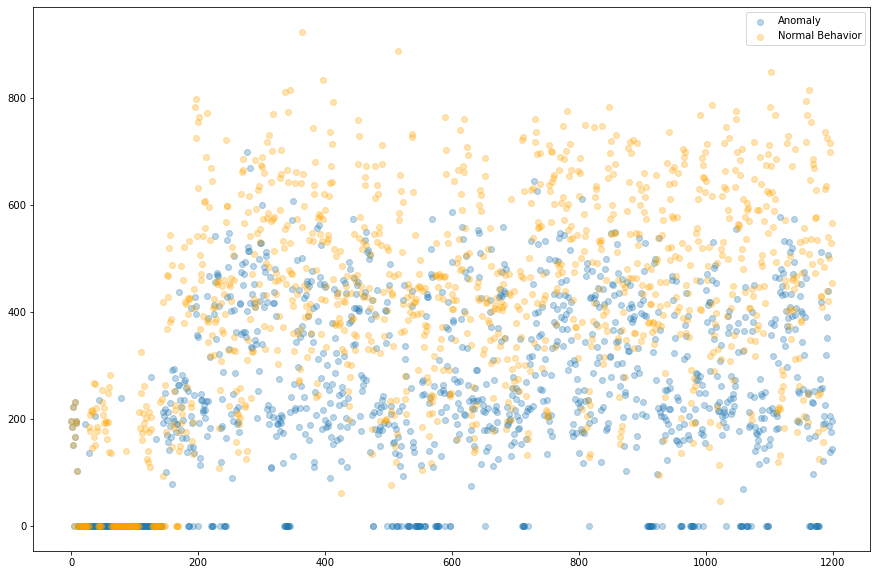

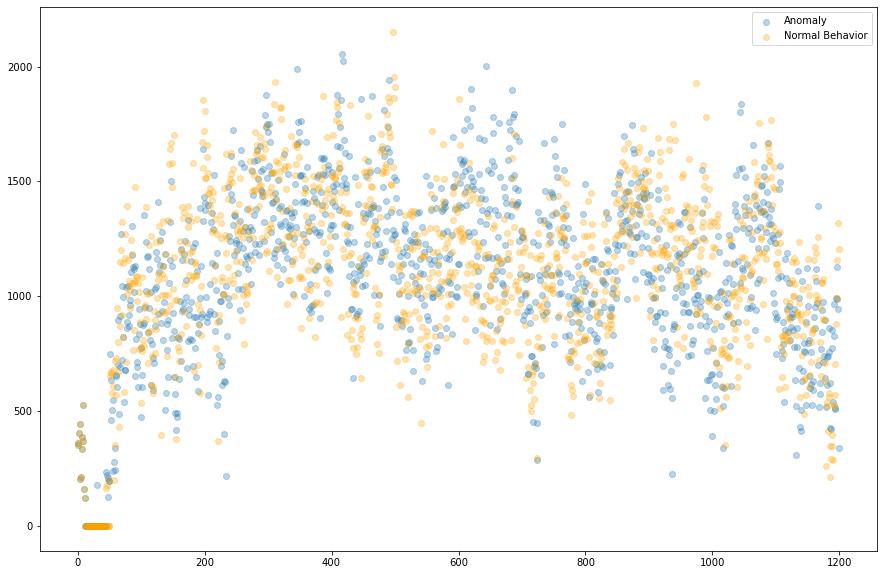

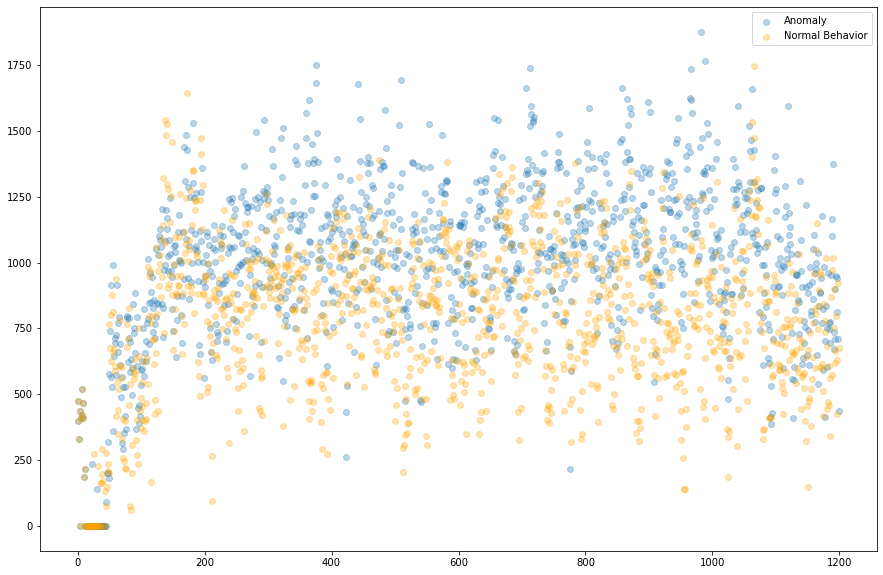

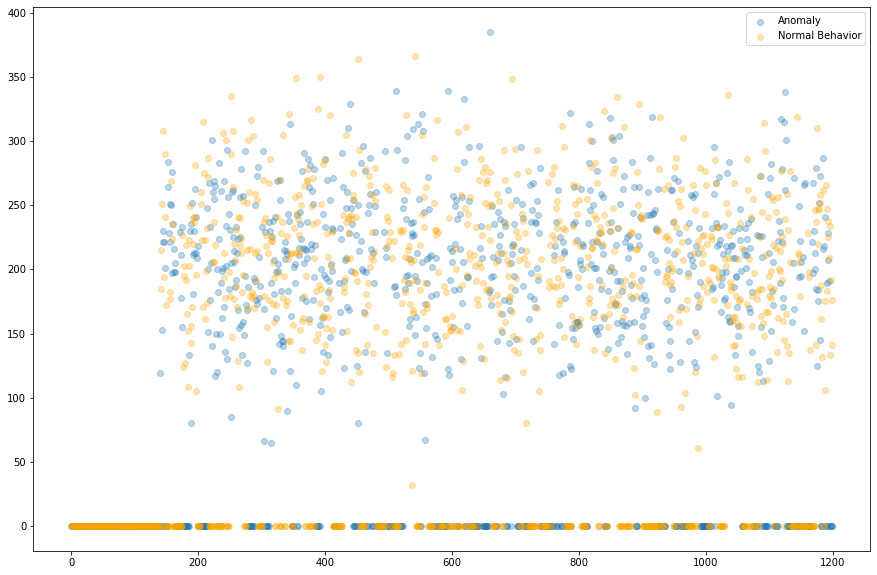

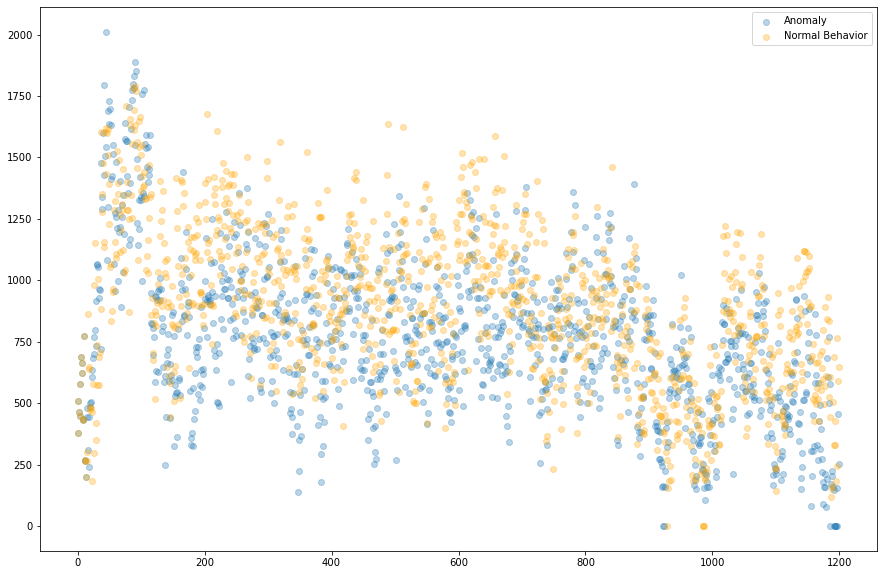

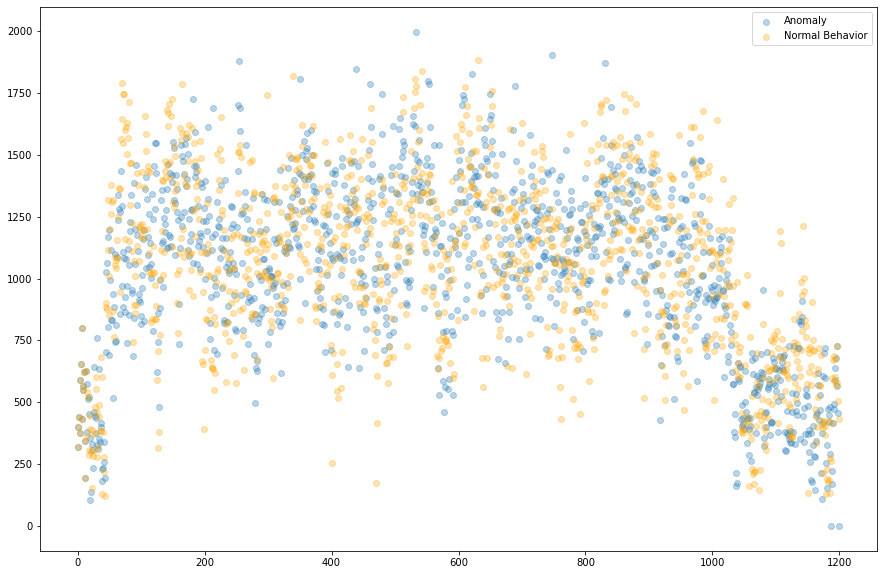

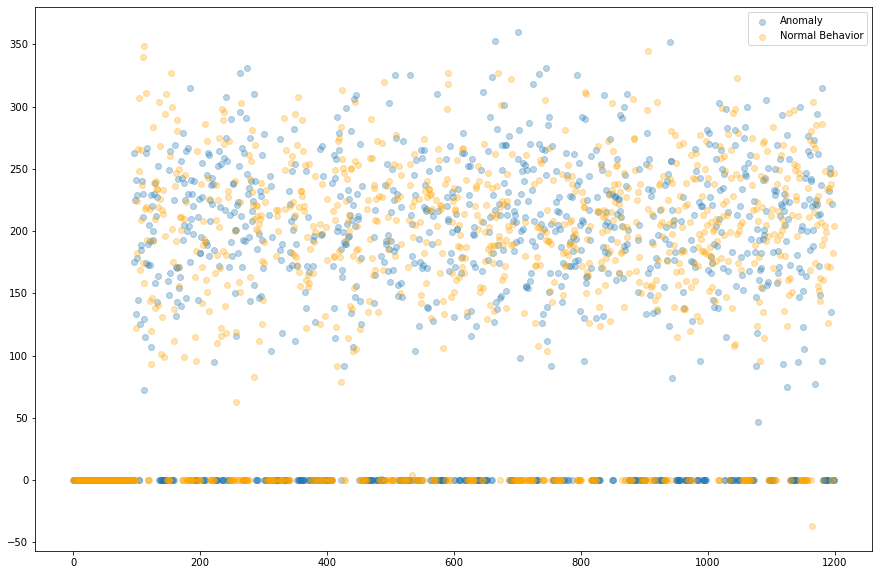

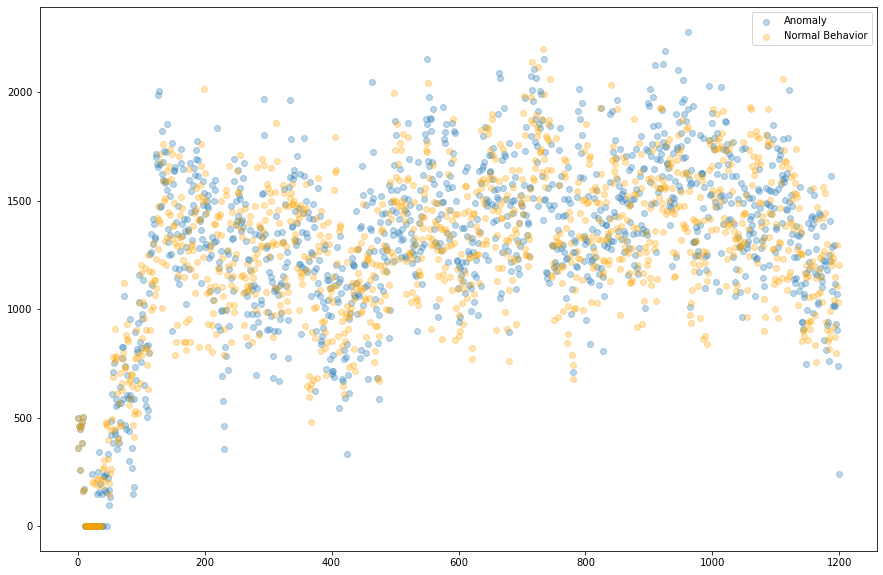

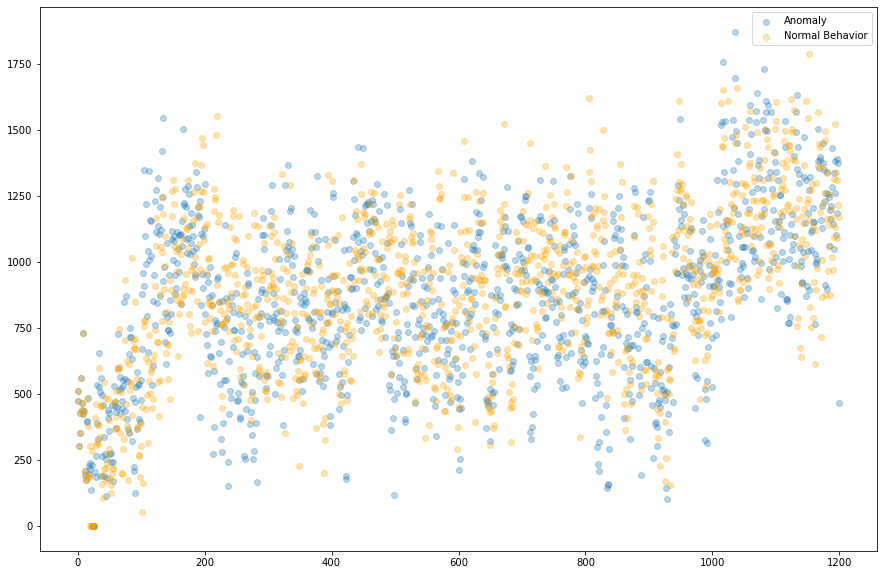

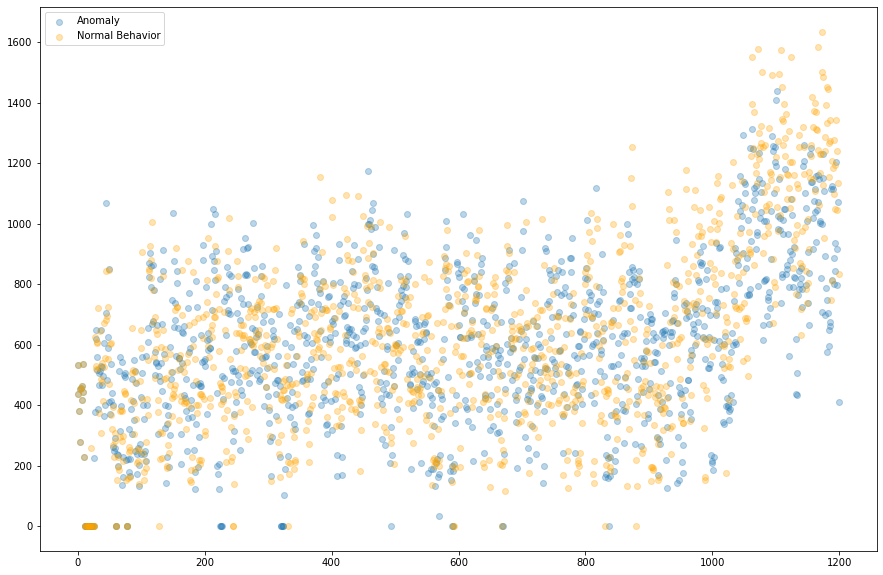

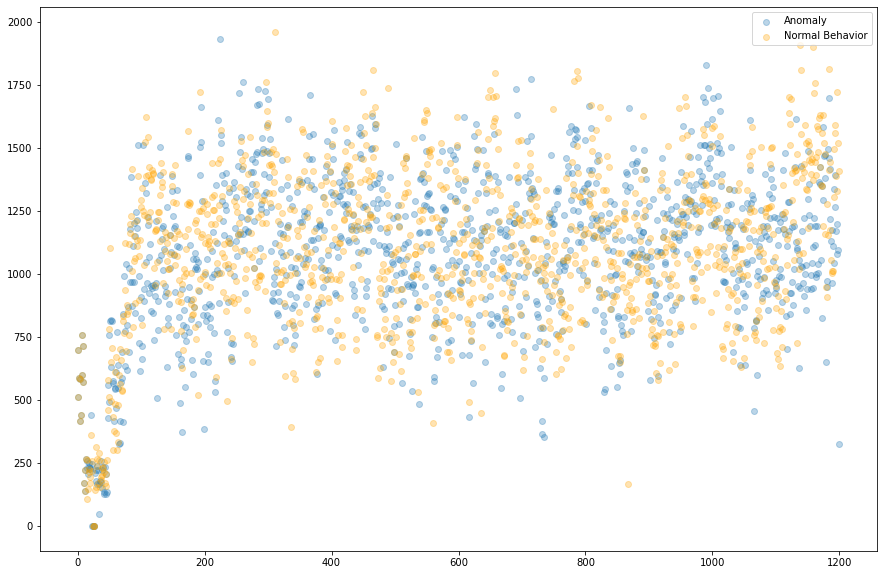

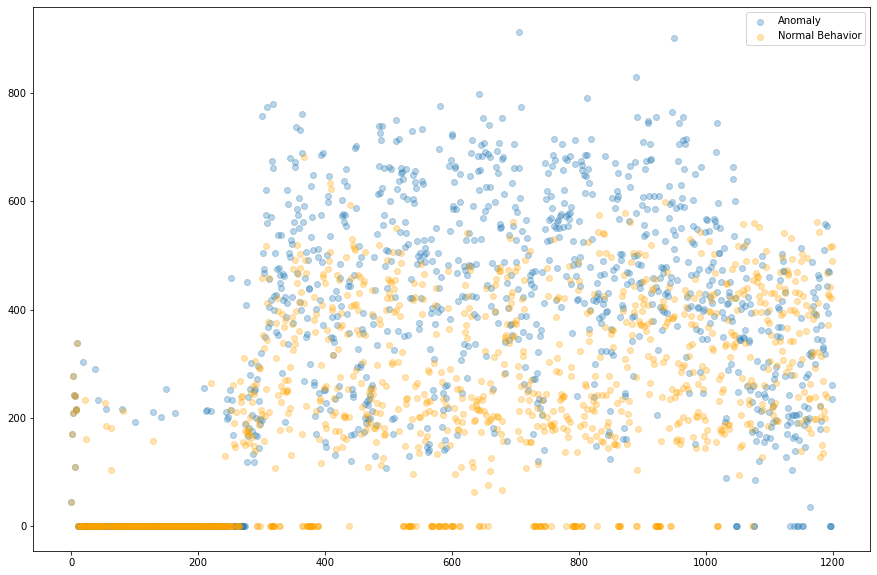

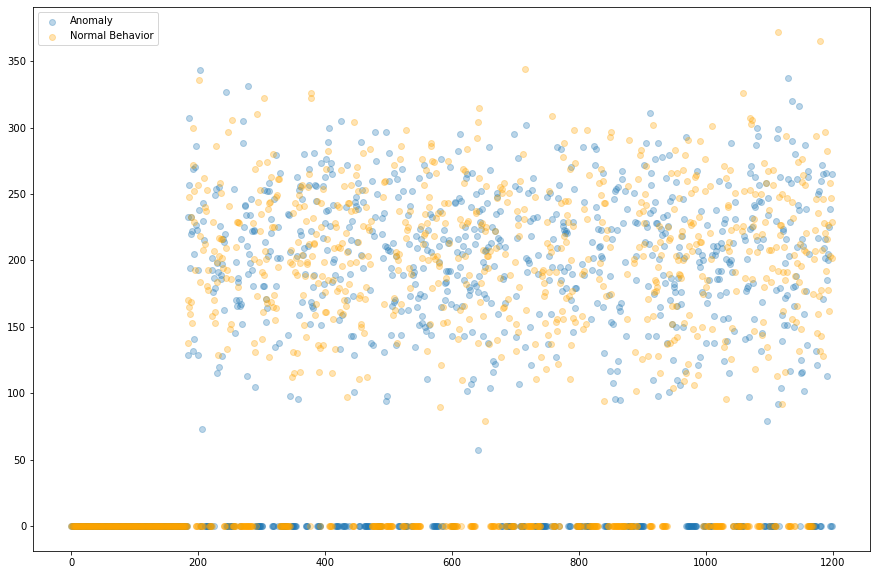

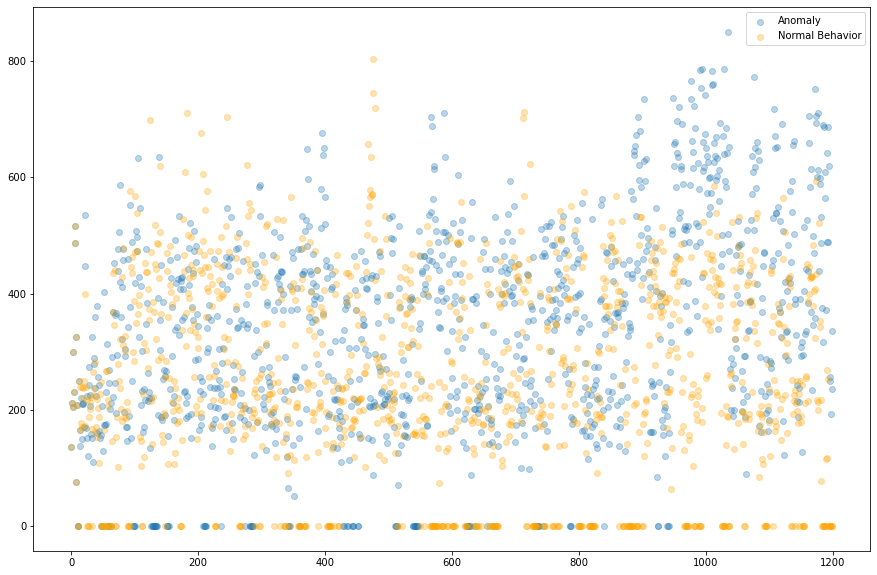

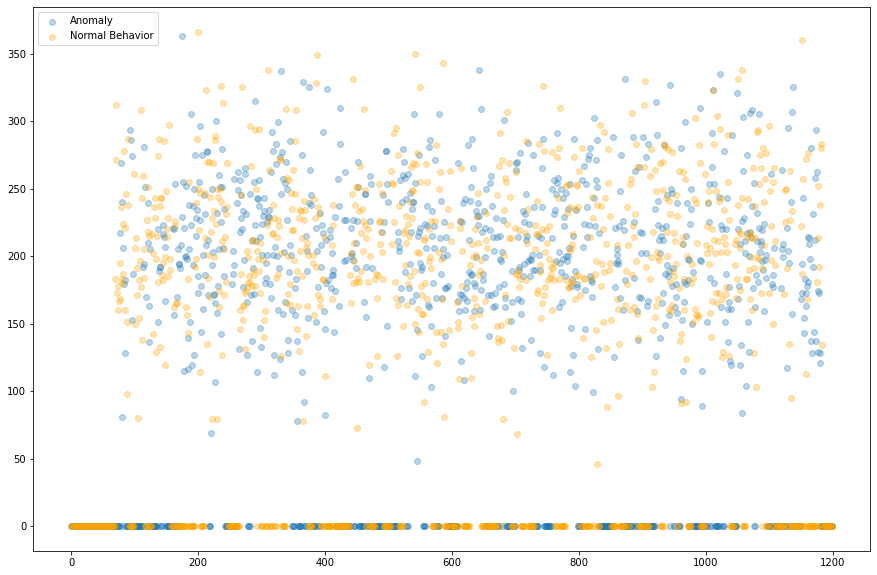

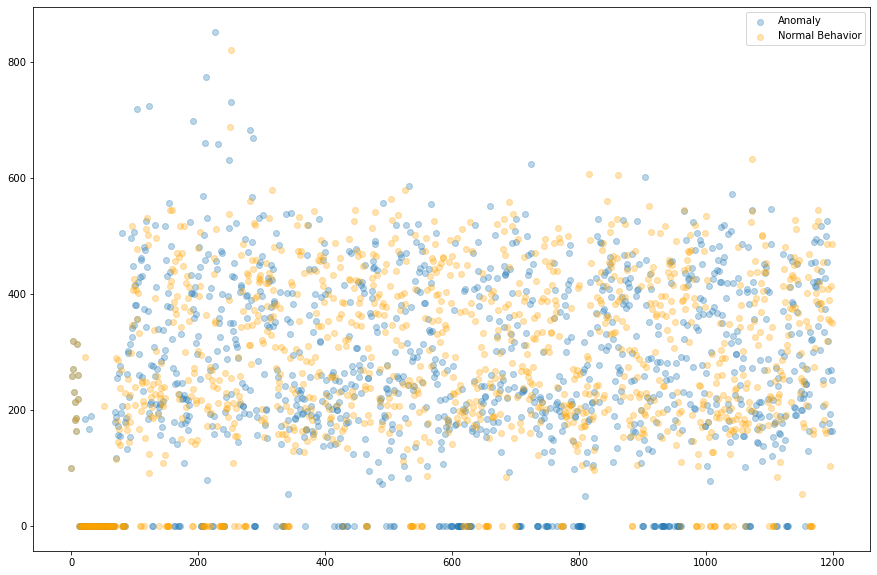

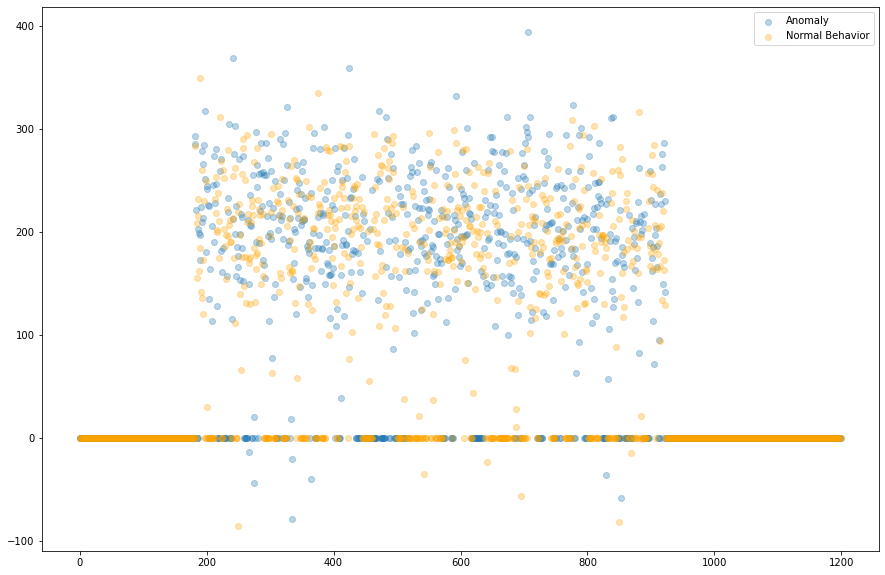

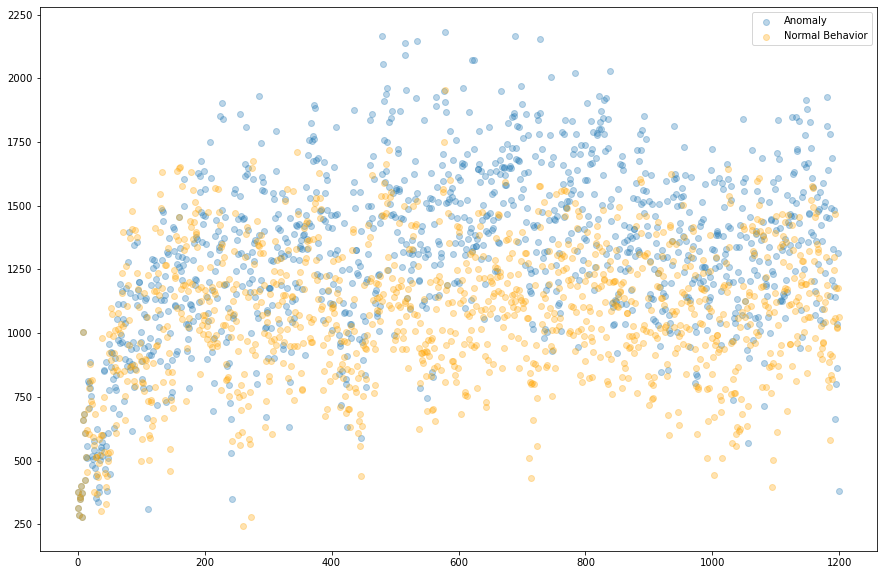

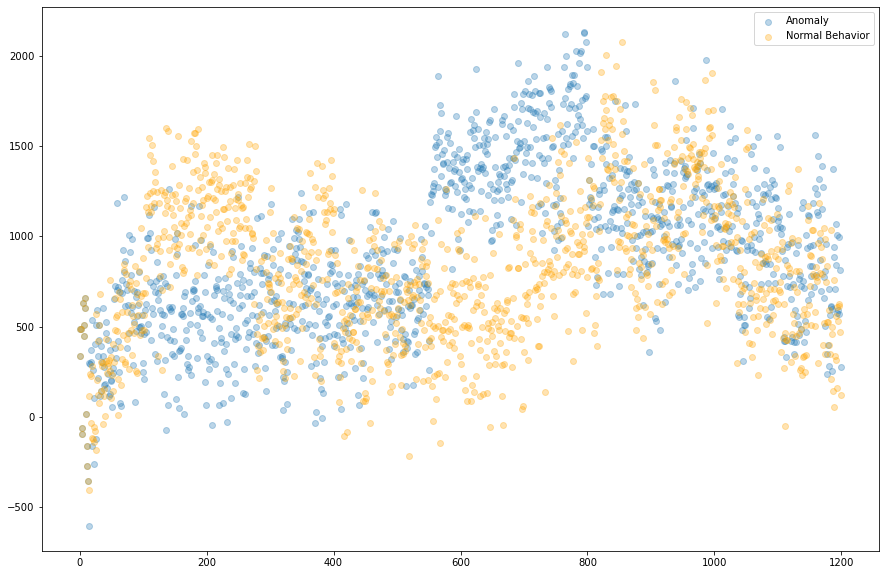

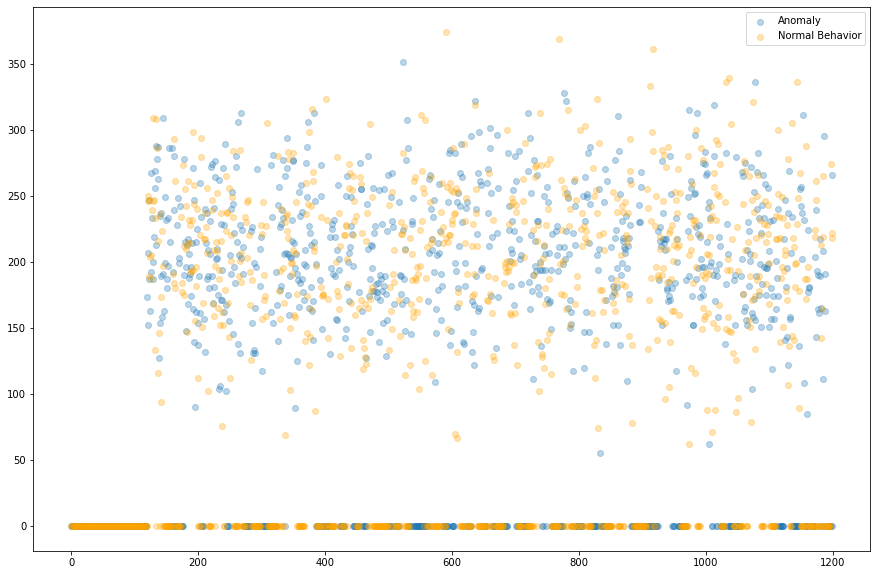

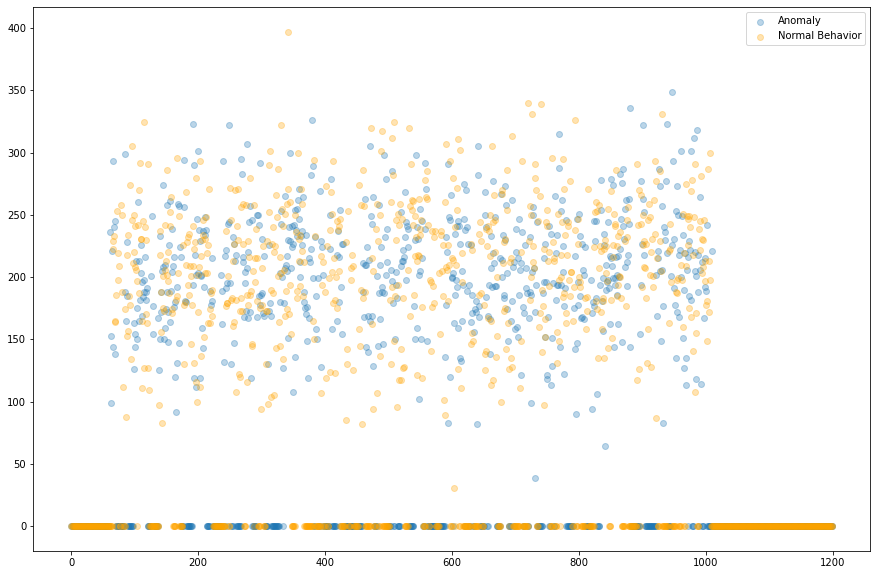

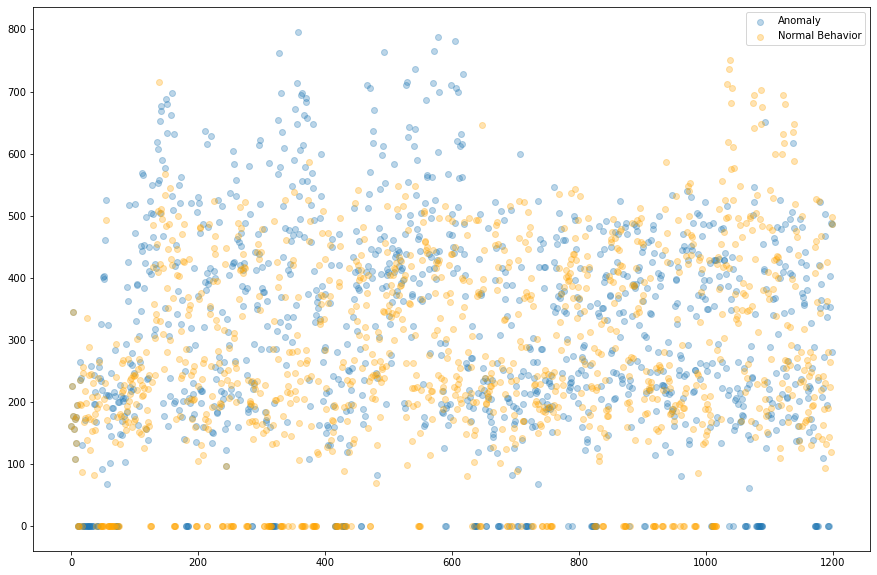

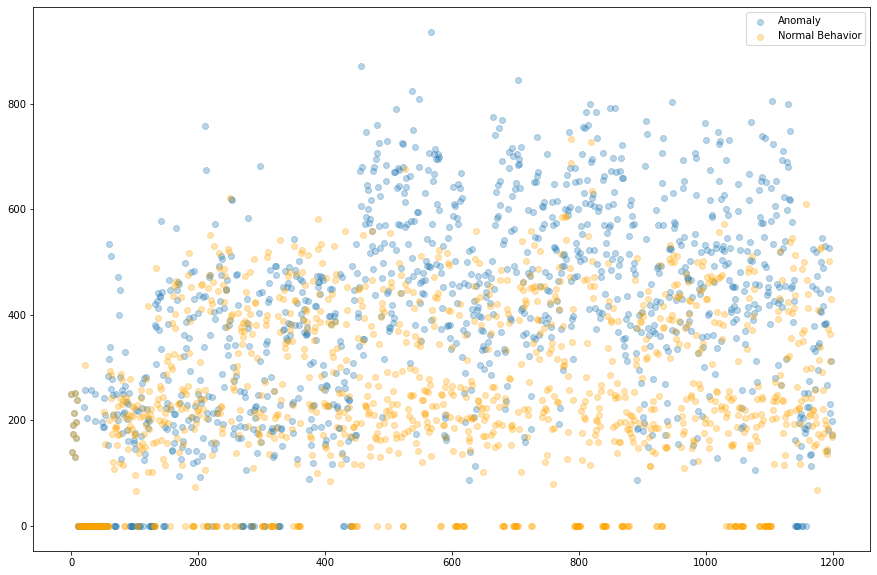

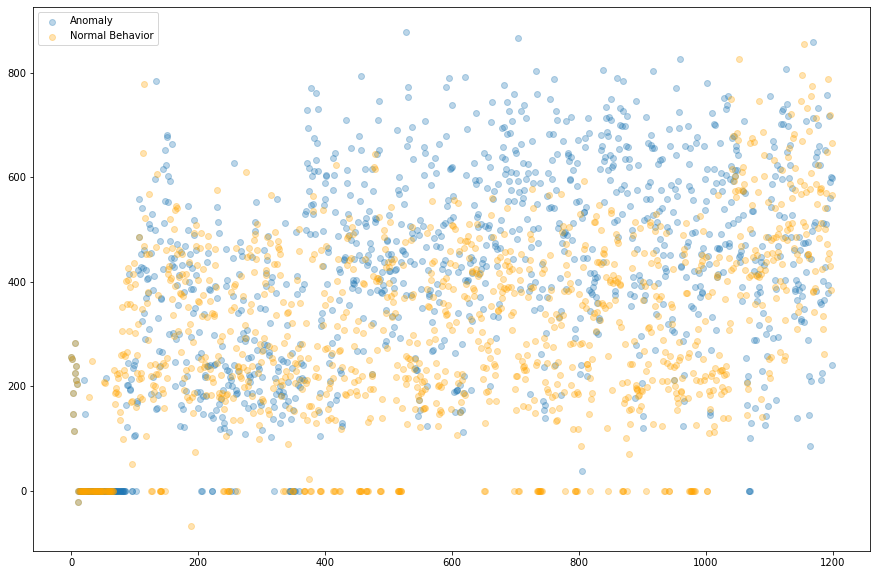

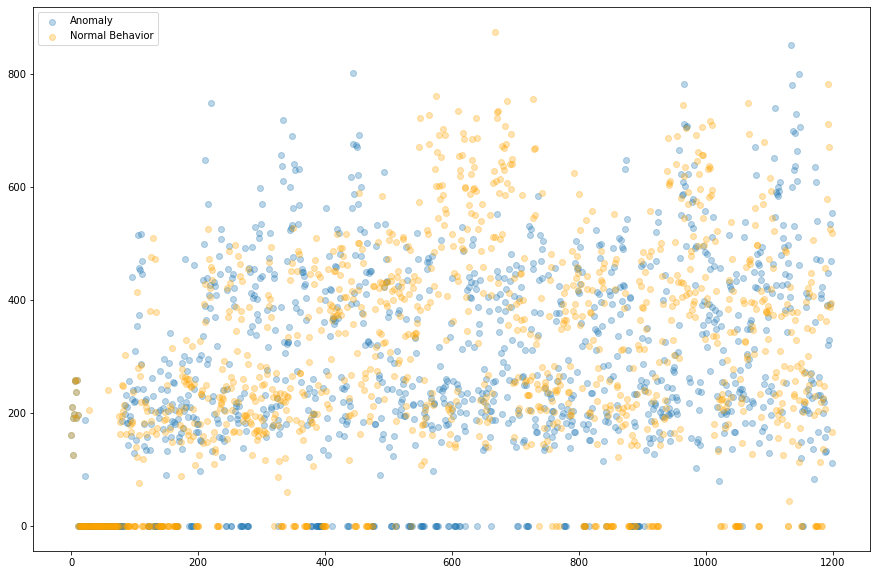

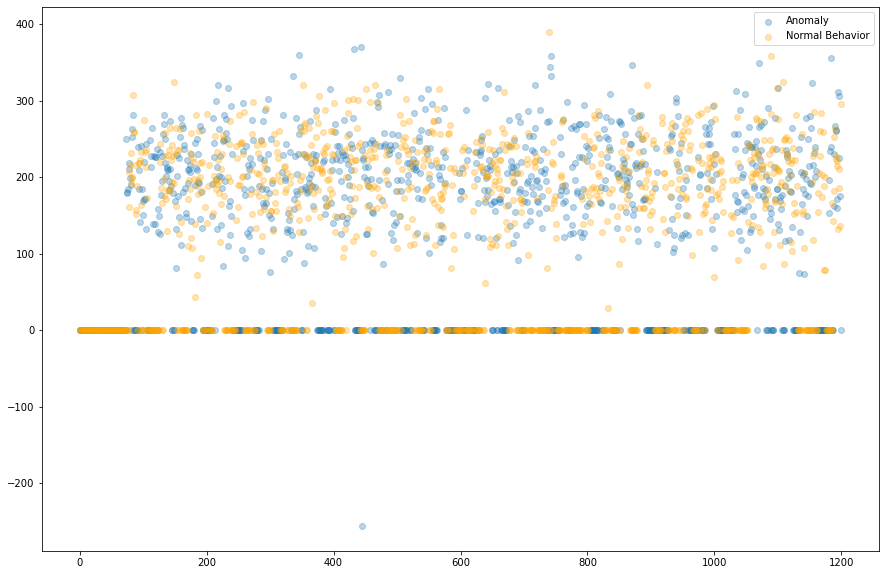

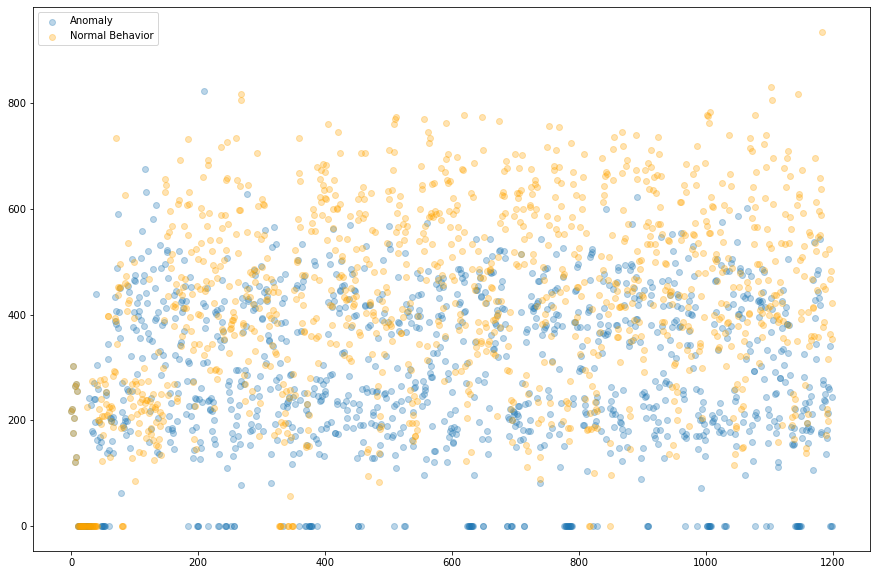

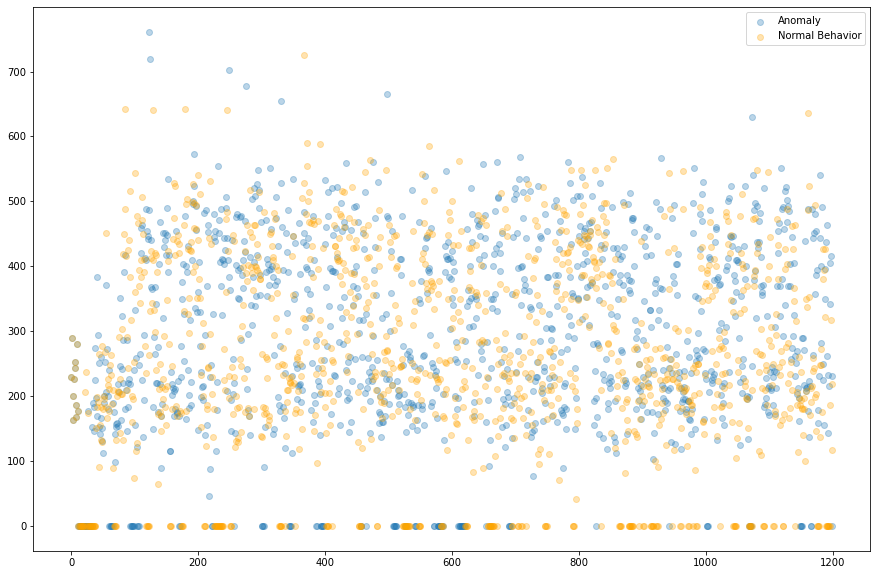

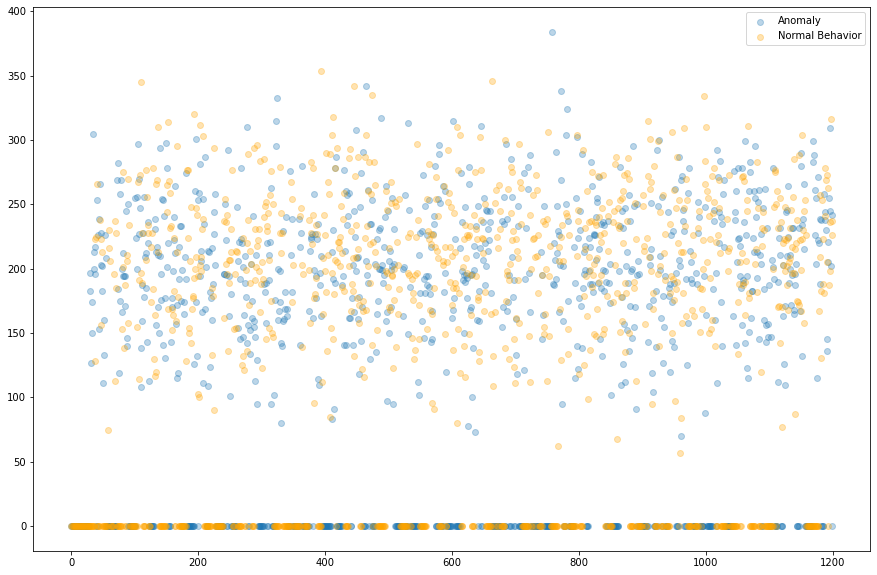

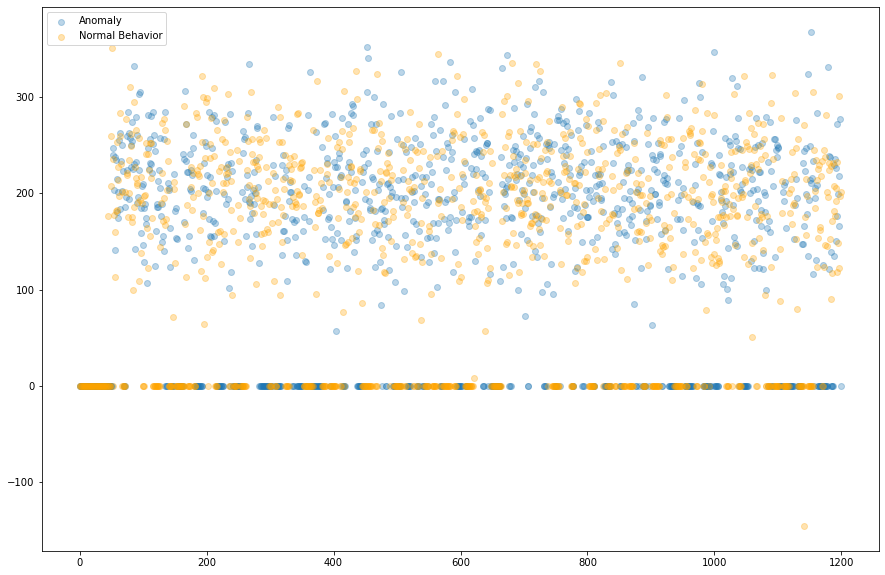

In [121]:
for host in column_names:
    plot_num_packets(net1_subtracted_data, net2_subtracted_data, host)

## Assigning "Attack" Labels

In [124]:
net2_subtracted_data.columns

Index(['13', '6', '9', '24', '8', '5', '29', '2', '3', '1', '7', '19', '23',
       '12', '20', '10', '28', '4', '0', '26', '25', '16', '11', '18', '15',
       '21', '14', '17', '27', '22'],
      dtype='object')

In [125]:
net2_subtracted_data.head(n=5)

13      6      9   24      8      5   29      2      3      1  ...   25  \
0  197.0  352.0  475.0  0.0  511.0  400.0  0.0  500.0  474.0  532.0  ...  0.0   
1  185.0  362.0  397.0  0.0  377.0  318.0  0.0  358.0  512.0  437.0  ...  0.0   
2  151.0  406.0  330.0  0.0  466.0  439.0  0.0  463.0  302.0  382.0  ...  0.0   
3  223.0  446.0  437.0  0.0  448.0  374.0  0.0  448.0  428.0  454.0  ...  0.0   
4    0.0  207.0    0.0  0.0  577.0  590.0  0.0  258.0  353.0  278.0  ...  0.0   

      16     11     18     15   21     14     17   27   22  
0  162.0  250.0  256.0  161.0  0.0  217.0  229.0  0.0  0.0  
1  226.0  141.0  251.0  210.0  0.0  221.0  289.0  0.0  0.0  
2  345.0  192.0  146.0  191.0  0.0  177.0  200.0  0.0  0.0  
3  178.0  175.0  187.0  125.0  0.0  303.0  163.0  0.0  0.0  
4  157.0  214.0  114.0  199.0  0.0  205.0  227.0  0.0  0.0  

[5 rows x 30 columns]

To assign attack labels, we will subtract the packets for the normal and anomaly data.  
0: [2*Lower Quartile, 2*Upper Quartile]  
1: otherwise  

In [153]:
def assign_attack_labels(normal_data, 
                         anomaly_data):
    all_data = {}
    for host in normal_data.columns:
        all_data[host] =  abs(normal_data[host]-anomaly_data[host])
    all_data = pd.DataFrame(all_data)
    
    
    all_host_stats = {}
    for host in all_data.columns:
        host_data = dict(all_data[host].describe())
        all_host_stats[host]=host_data
        
    all_host_stats
    anomaly_times = set()
    for host in all_data.columns:
        min_accepted_value = -2*all_host_stats[host]["25%"]
        max_accepted_value =  2*all_host_stats[host]["75%"]
        for index, row in all_data.iterrows():
            value = row[host]
            if (value < min_accepted_value or value > max_accepted_value) and (int(value) != 0):
                anomaly_times.add(index)
                
    anomaly_data["attack"] = [0 for i in range(len(anomaly_data))]
    for index, row in anomaly_data.iterrows():
        if index in anomaly_times:
            anomaly_data["attack"][index]= 1
    return anomaly_data, anomaly_times


In [154]:
net2_with_labels, anomaly_times = assign_attack_labels(net1_subtracted_data, net2_subtracted_data)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [155]:
net2_with_labels

13       6      9   24      8      5     29       2       3       1  \
0     197.0   352.0  475.0  0.0  511.0  400.0    0.0   500.0   474.0   532.0   
1     185.0   362.0  397.0  0.0  377.0  318.0    0.0   358.0   512.0   437.0   
2     151.0   406.0  330.0  0.0  466.0  439.0    0.0   463.0   302.0   382.0   
3     223.0   446.0  437.0  0.0  448.0  374.0    0.0   448.0   428.0   454.0   
4       0.0   207.0    0.0  0.0  577.0  590.0    0.0   258.0   353.0   278.0   
...     ...     ...    ...  ...    ...    ...    ...     ...     ...     ...   
1195  206.0   993.0  948.0  0.0    0.0  677.0  222.0   931.0  1103.0  1203.0   
1196  138.0  1128.0  941.0  0.0    0.0  565.0    0.0  1072.0  1390.0   796.0   
1197  176.0   988.0  813.0  0.0  156.0  726.0    0.0   905.0  1186.0   916.0   
1198  196.0   947.0  708.0  0.0  455.0  457.0    0.0   739.0  1375.0  1073.0   
1199  144.0   339.0  437.0  0.0  254.0    0.0    0.0   242.0   468.0   411.0   

      ...     16     11     18     15     21     14     17     27     22  \
0     ...  162.0  250.0  256.0  161.0    0.0  217.0  229.0    0.0    0.0   
1     ...  226.0  141.0  251.0  210.0    0.0  221.0  289.0    0.0    0.0   
2     ...  345.0  192.0  146.0  191.0    0.0  177.0  200.0    0.0    0.0   
3     ...  178.0  175.0  187.0  125.0    0.0  303.0  163.0    0.0    0.0   
4     ...  157.0  214.0  114.0  199.0    0.0  205.0  227.0    0.0    0.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1195  ...  403.0  231.0  560.0  534.0  312.0  340.0  342.0  309.0  199.0   
1196  ...  353.0  214.0  590.0  393.0  225.0    0.0  405.0  245.0  166.0   
1197  ...  488.0  312.0  600.0  469.0  306.0    0.0  416.0  202.0  218.0   
1198  ...  487.0  173.0  599.0  554.0  175.0    0.0  231.0  242.0  277.0   
1199  ...  281.0  199.0  240.0  112.0    0.0  244.0    0.0    0.0    0.0   

      attack  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
1195       0  
1196       0  
1197       0  
1198       0  
1199       1  

[1200 rows x 31 columns]

In [156]:
# Notice how there are no zeros in the anomaly times
print(sorted(list(anomaly_times)))

[52, 69, 71, 74, 77, 80, 81, 86, 90, 103, 115, 123, 124, 128, 130, 134, 136, 138, 139, 148, 150, 151, 153, 154, 155, 157, 161, 171, 177, 179, 181, 183, 193, 196, 197, 199, 200, 203, 206, 208, 209, 210, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 226, 227, 231, 233, 234, 236, 237, 238, 242, 244, 251, 252, 254, 256, 260, 262, 268, 274, 275, 278, 283, 287, 289, 295, 311, 316, 317, 318, 322, 326, 330, 331, 332, 333, 336, 338, 340, 341, 342, 344, 347, 351, 352, 358, 359, 362, 363, 364, 365, 366, 368, 369, 370, 375, 376, 378, 379, 380, 381, 382, 383, 386, 387, 390, 400, 401, 404, 405, 412, 414, 415, 416, 418, 424, 444, 445, 447, 449, 454, 456, 457, 463, 470, 471, 472, 475, 480, 481, 488, 489, 496, 497, 502, 503, 507, 509, 510, 515, 516, 522, 523, 528, 529, 534, 543, 551, 552, 556, 561, 565, 567, 568, 570, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 585, 589, 594, 598, 599, 600, 603, 604, 605, 607, 611, 612, 613, 615, 617, 620, 621, 622, 624, 628, 630, 633, 634, 638, 639, 640, 641

In [157]:
# Fraction of data classified as anomalies
len(anomaly_times)/1200

0.3333333333333333

In [159]:
# Verifying the attack column has been populated properly. Recall, there were 400 anomalies identified from our method above
sum(net2_with_labels["attack"])

400

In [160]:
net2_with_labels.columns

Index(['13', '6', '9', '24', '8', '5', '29', '2', '3', '1', '7', '19', '23',
       '12', '20', '10', '28', '4', '0', '26', '25', '16', '11', '18', '15',
       '21', '14', '17', '27', '22', 'attack'],
      dtype='object')

In [161]:
net2_with_labels.head(4)

13      6      9   24      8      5   29      2      3      1  ...  \
0  197.0  352.0  475.0  0.0  511.0  400.0  0.0  500.0  474.0  532.0  ...   
1  185.0  362.0  397.0  0.0  377.0  318.0  0.0  358.0  512.0  437.0  ...   
2  151.0  406.0  330.0  0.0  466.0  439.0  0.0  463.0  302.0  382.0  ...   
3  223.0  446.0  437.0  0.0  448.0  374.0  0.0  448.0  428.0  454.0  ...   

      16     11     18     15   21     14     17   27   22  attack  
0  162.0  250.0  256.0  161.0  0.0  217.0  229.0  0.0  0.0       0  
1  226.0  141.0  251.0  210.0  0.0  221.0  289.0  0.0  0.0       0  
2  345.0  192.0  146.0  191.0  0.0  177.0  200.0  0.0  0.0       0  
3  178.0  175.0  187.0  125.0  0.0  303.0  163.0  0.0  0.0       0  

[4 rows x 31 columns]

Plotting the number of packets sent - received. This way we can see where the anomalies actually lie. 

In [168]:
def plot_num_packets_overlay_attack(normal, anomaly, host):
    fig = plt.figure(figsize=(15, 10))
    title = "Packets for Host " + host
    plt.scatter(anomaly.index, anomaly[host], alpha = 0.3, label="Anomaly")
    plt.scatter(normal.index, normal[host], alpha=0.3, color = "orange", label= "Normal Behavior")
    plt.scatter(normal.index, anomaly["attack"], alpha=0.3, color = "red", label= "Classified Anomaly")
    plt.legend()

In [169]:
column_names = net2_with_labels.columns[:-1]
column_names

Index(['13', '6', '9', '24', '8', '5', '29', '2', '3', '1', '7', '19', '23',
       '12', '20', '10', '28', '4', '0', '26', '25', '16', '11', '18', '15',
       '21', '14', '17', '27', '22'],
      dtype='object')

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


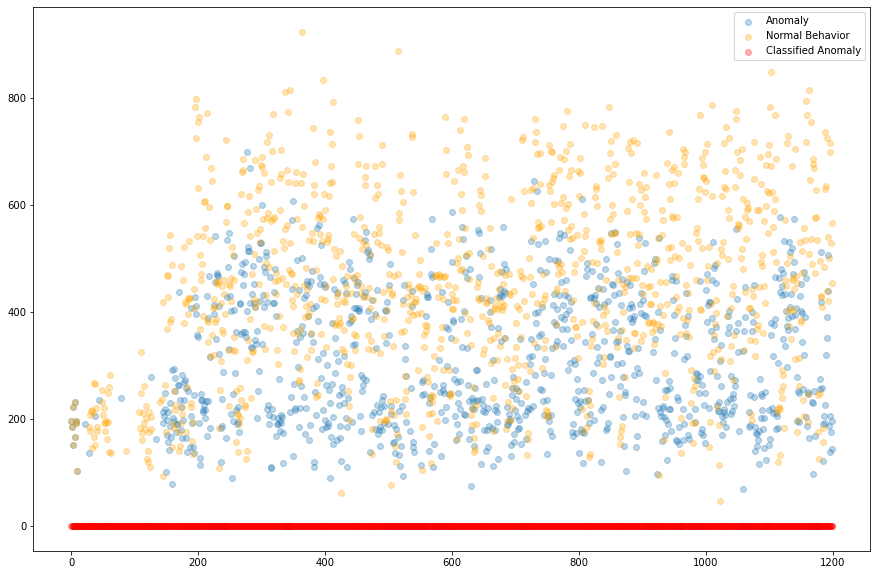

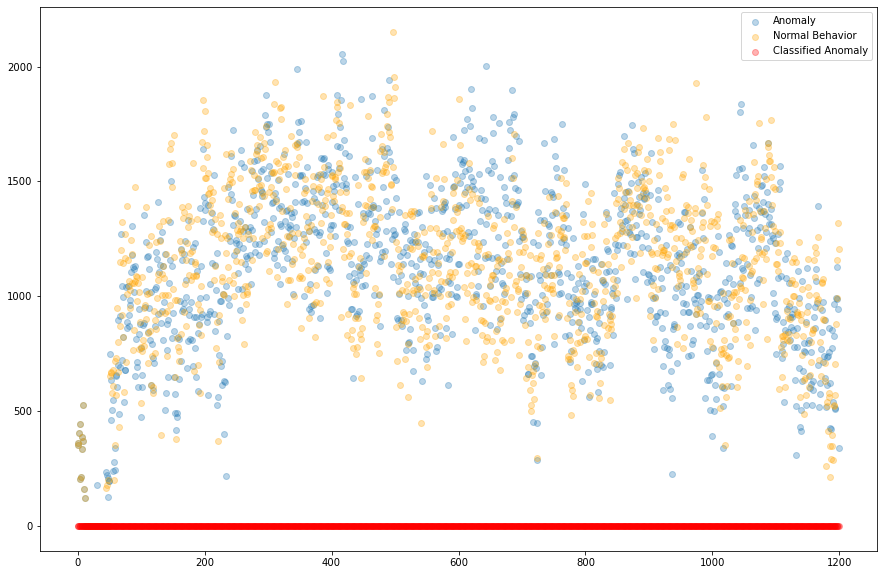

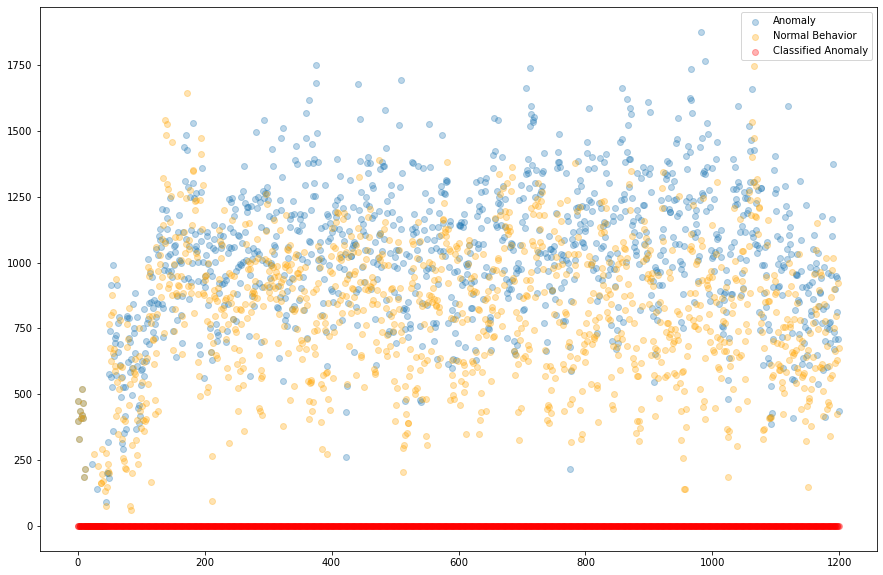

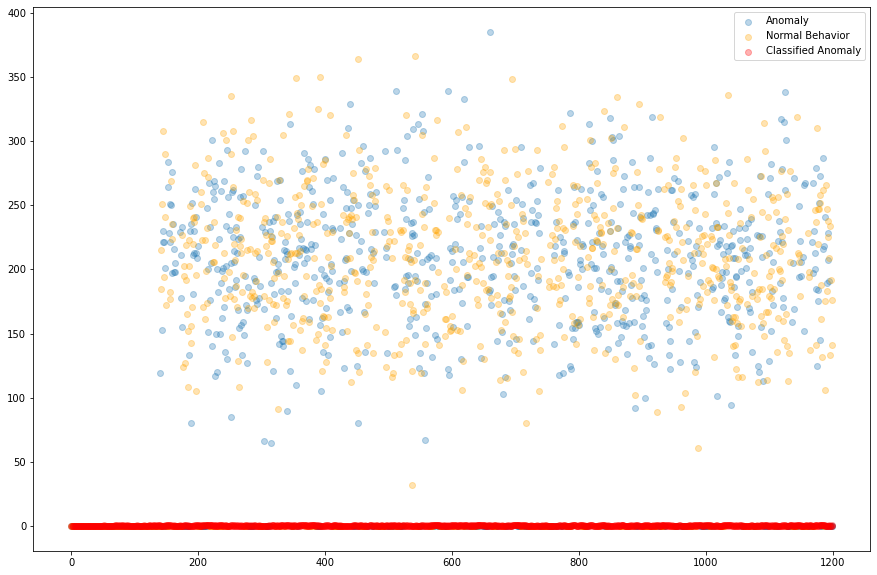

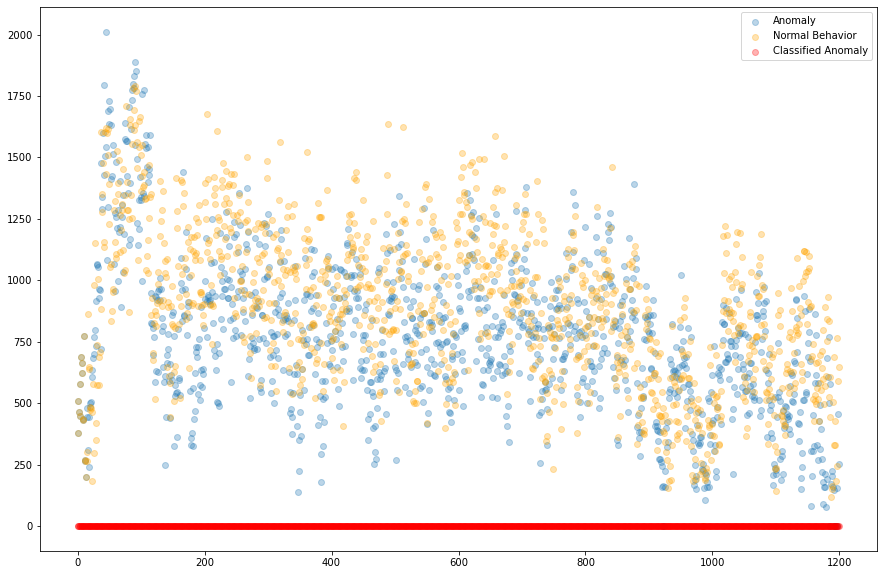

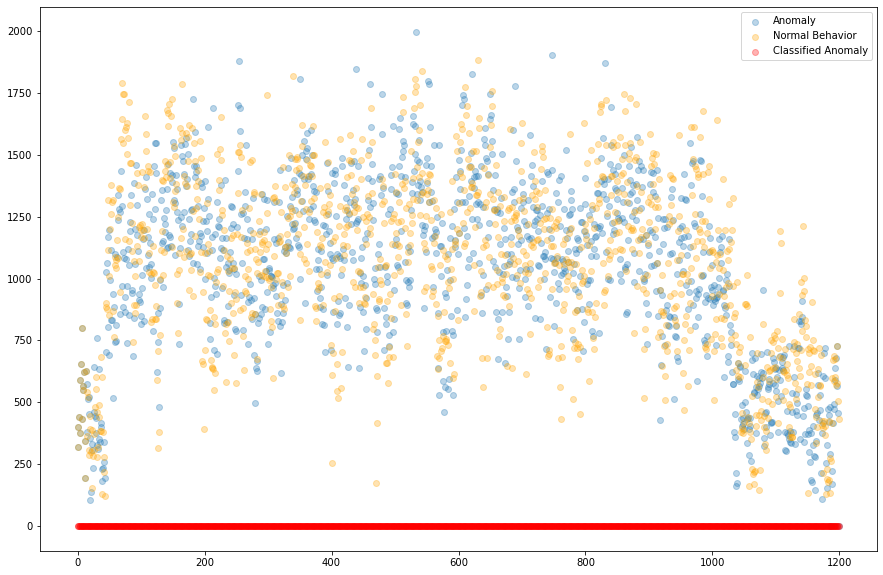

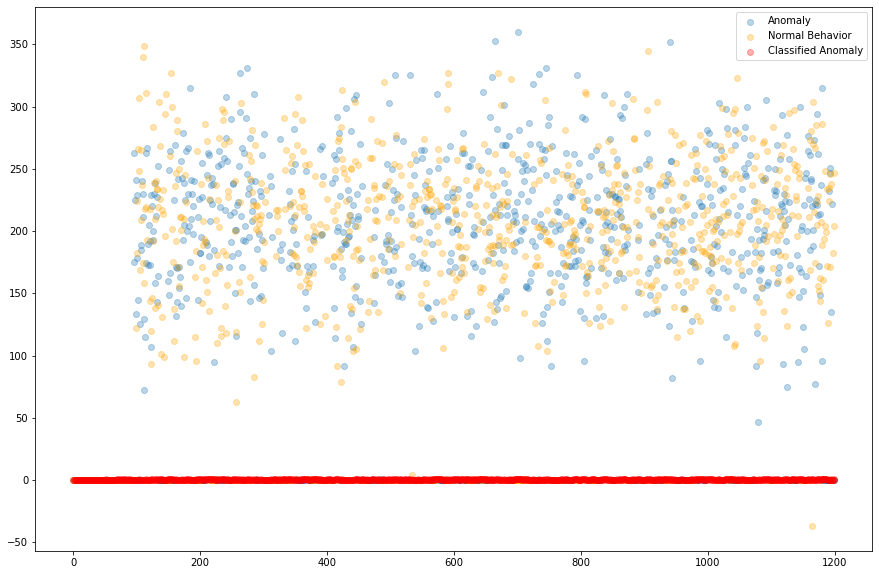

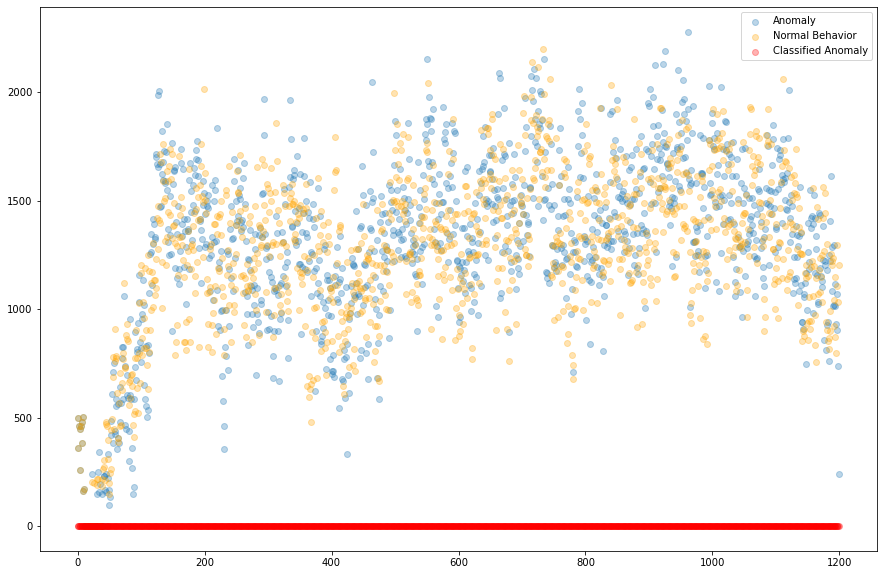

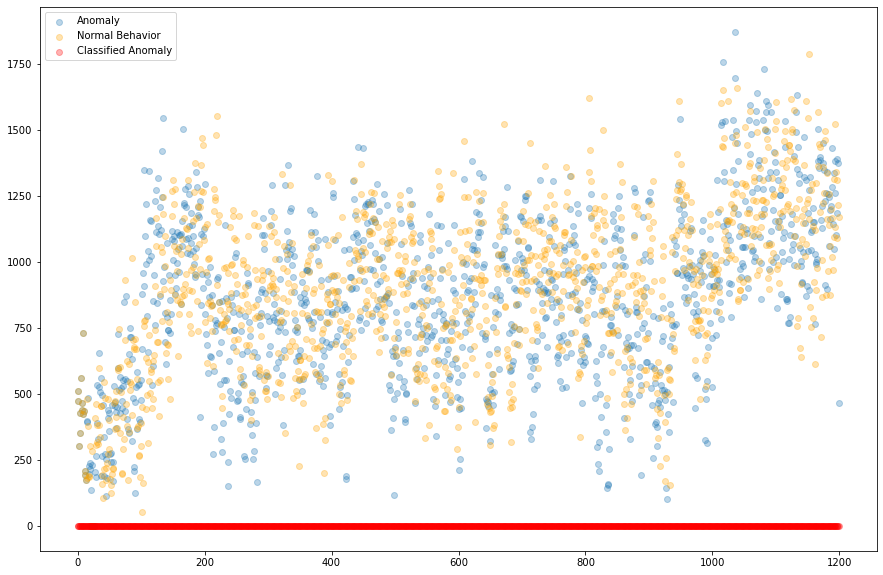

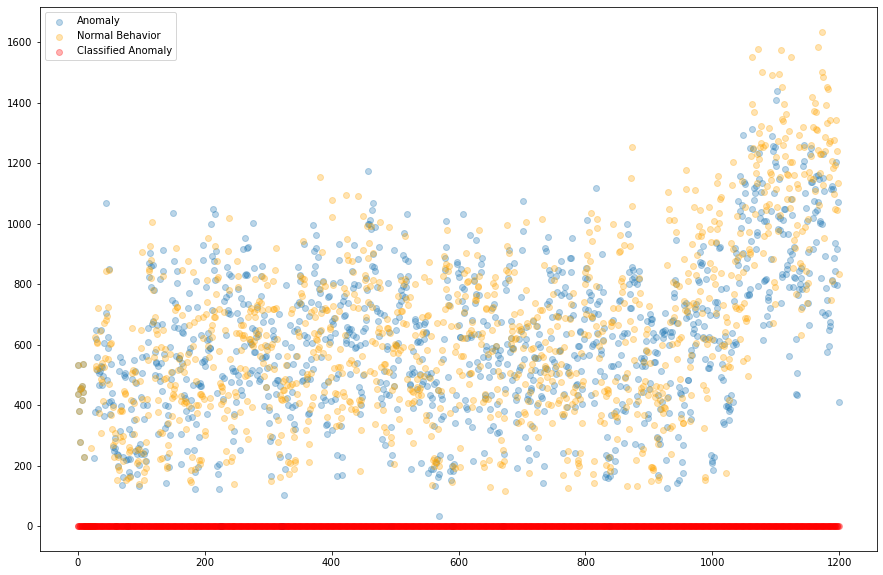

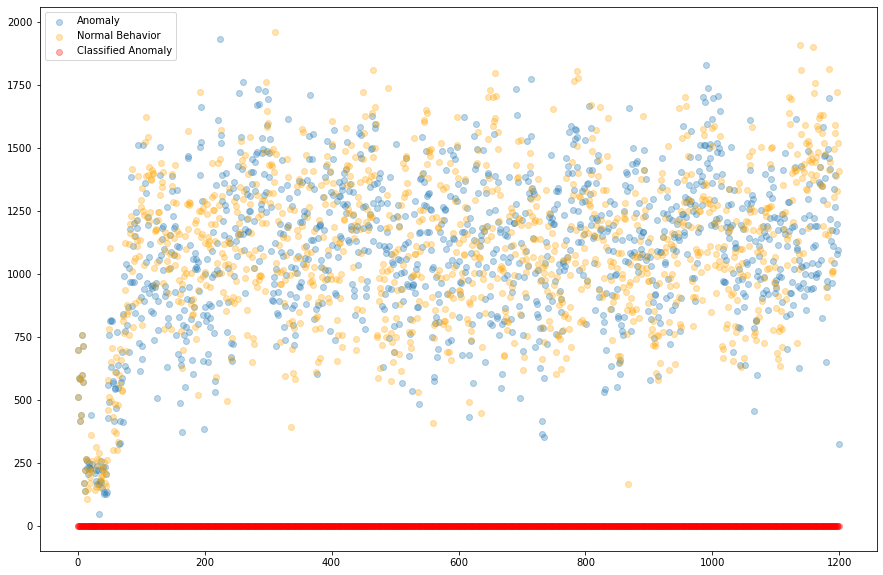

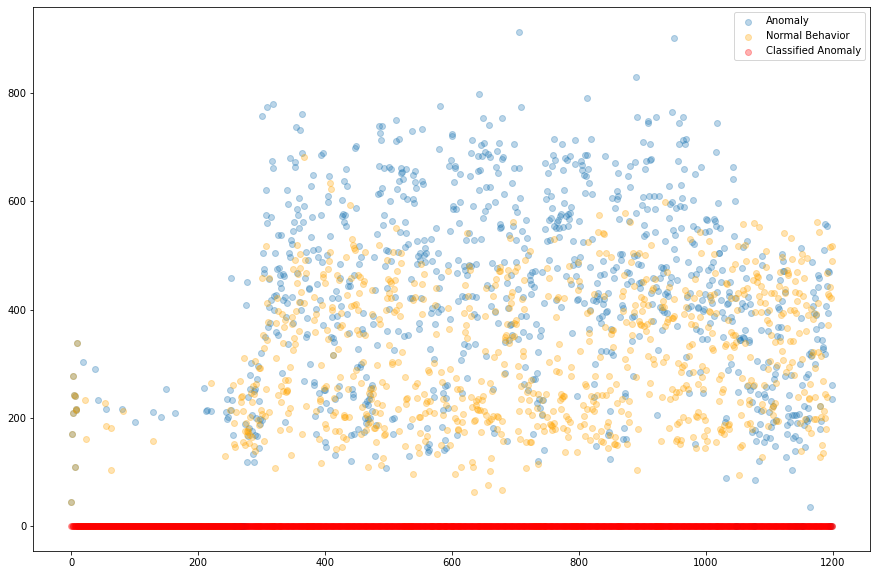

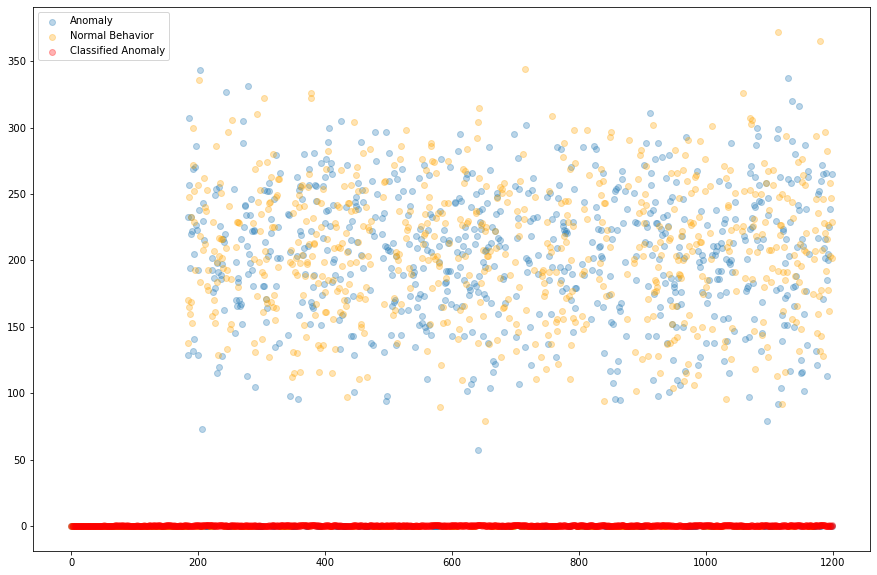

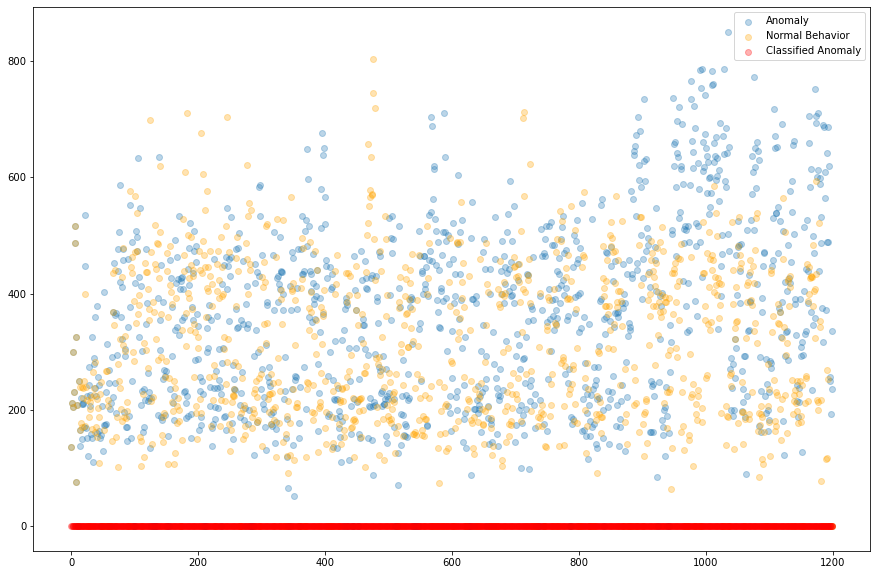

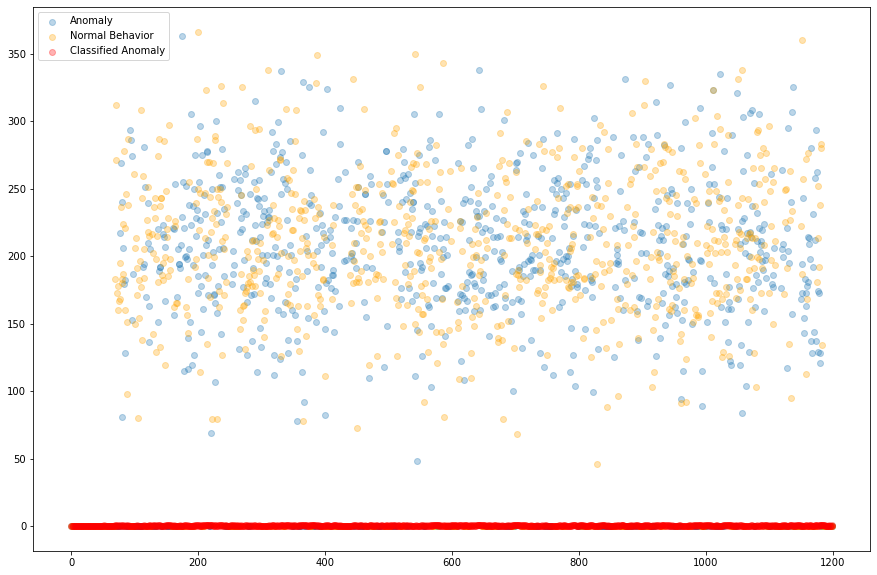

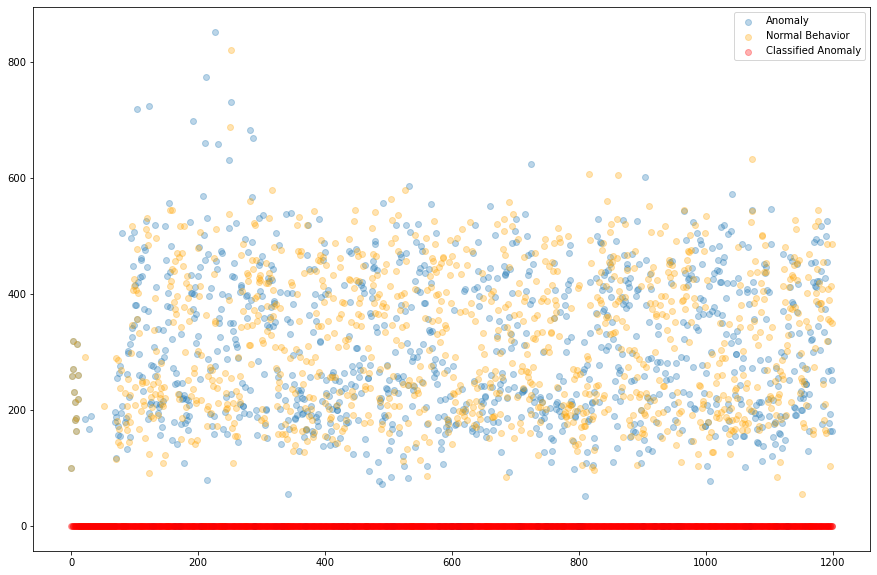

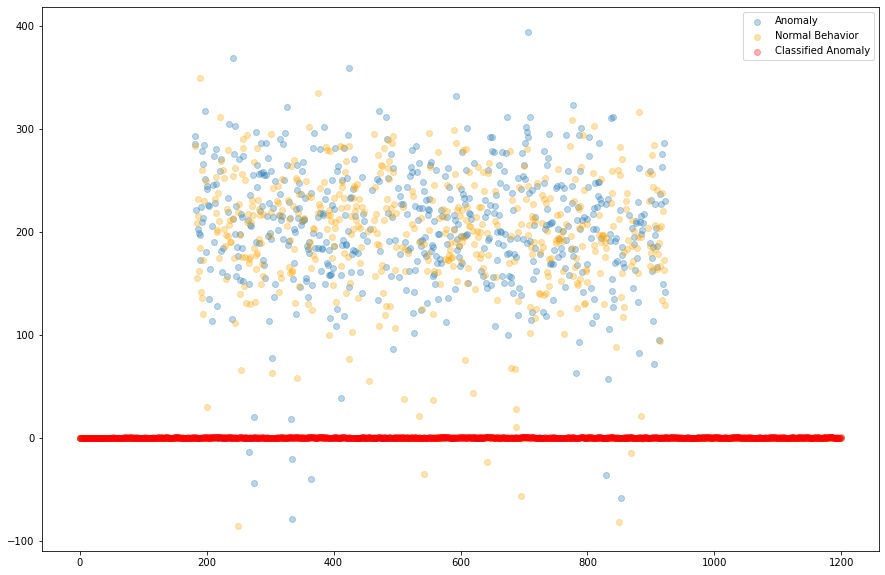

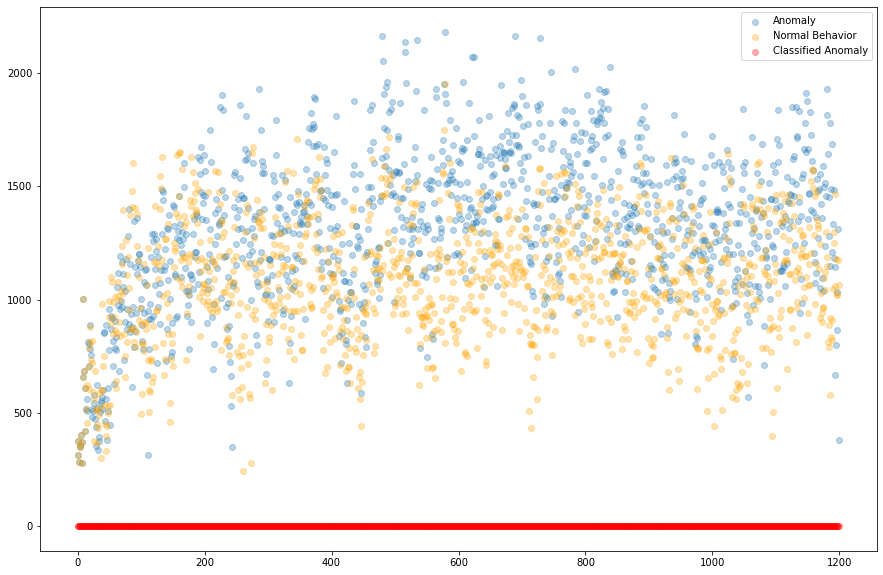

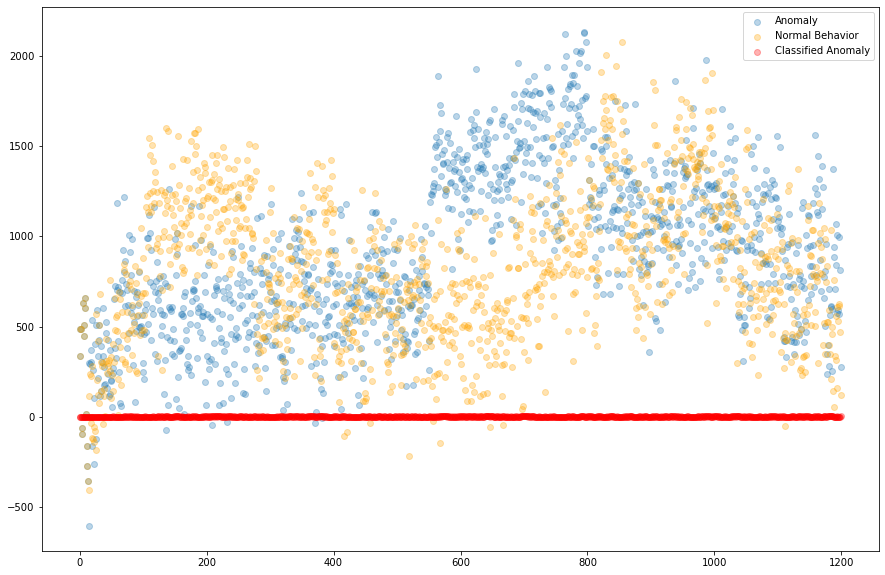

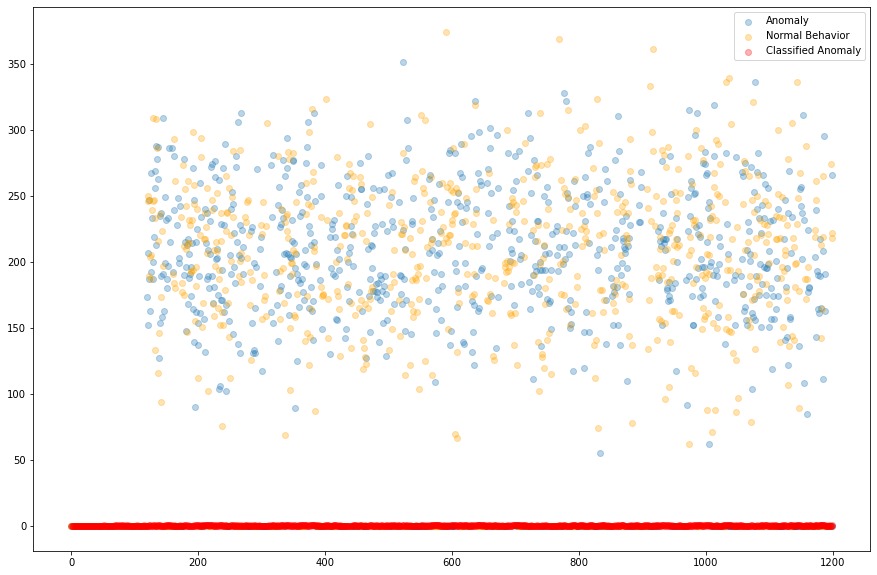

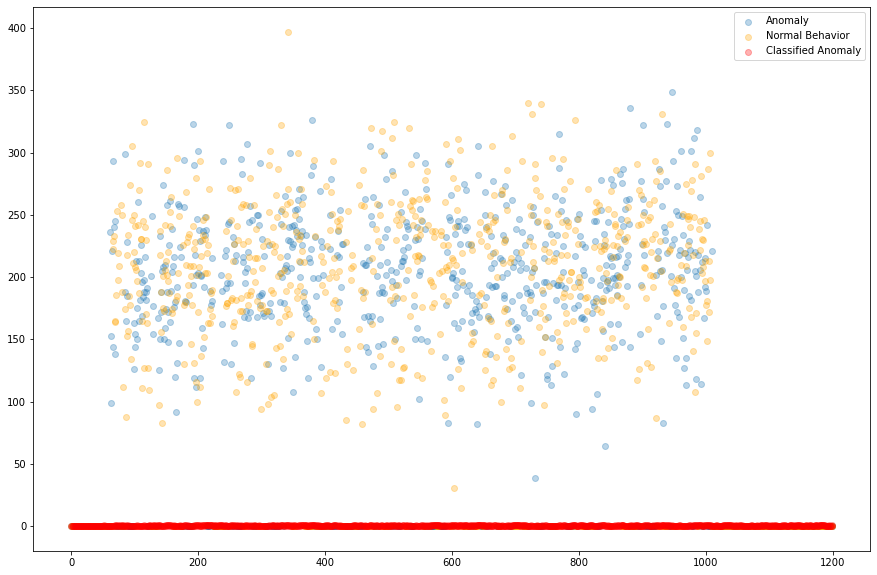

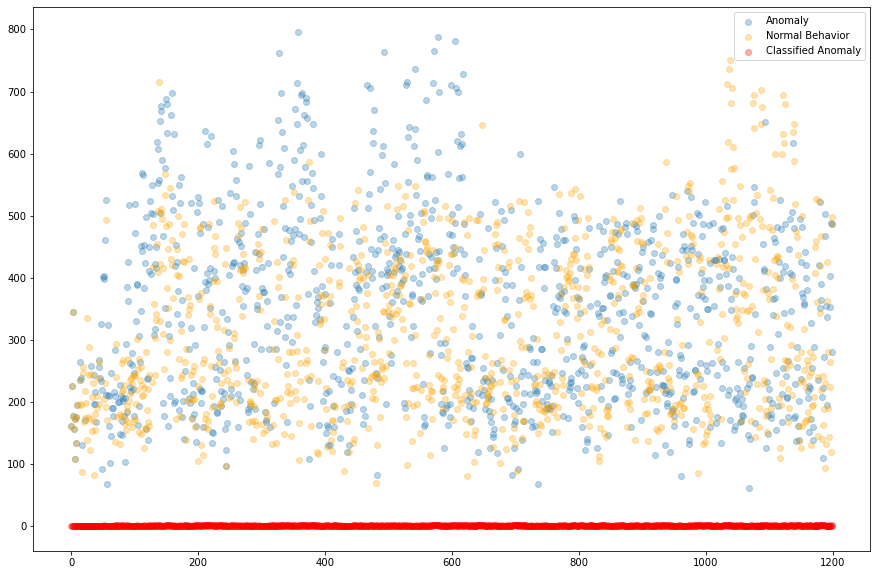

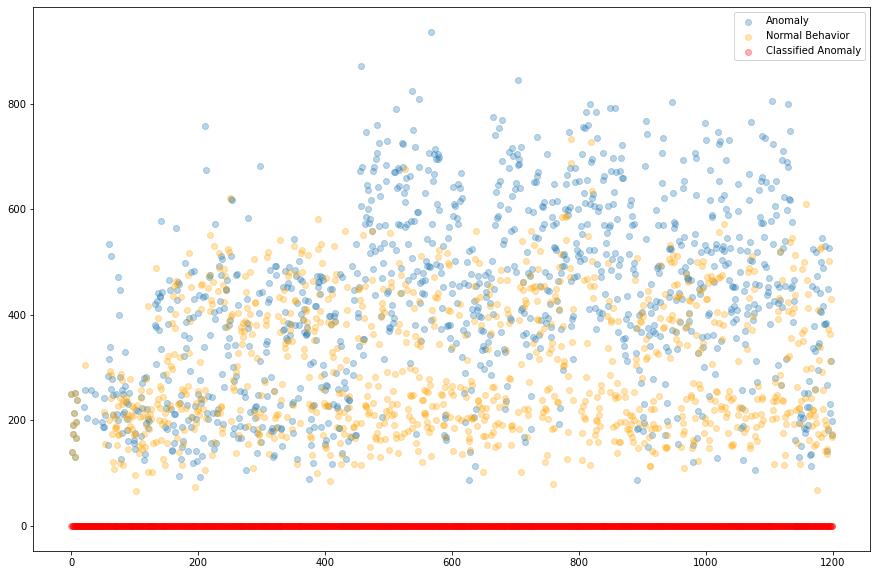

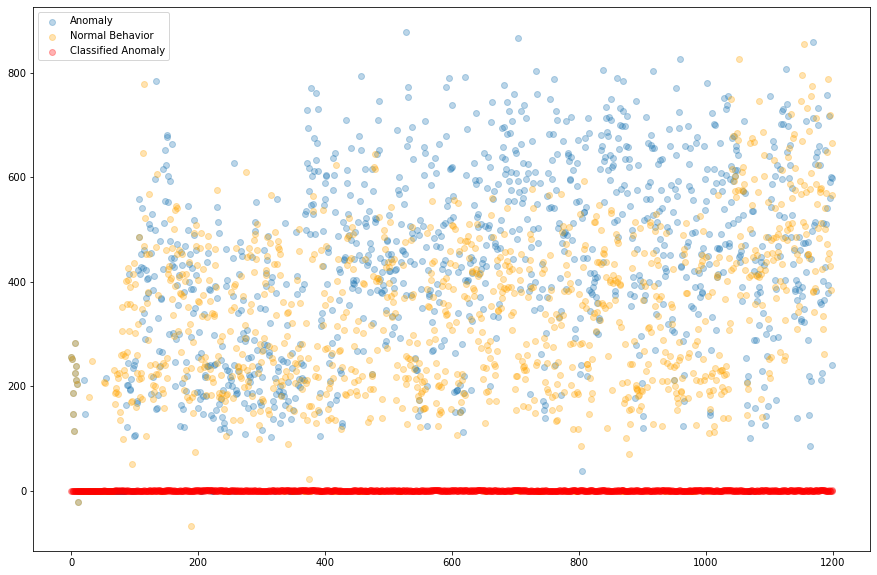

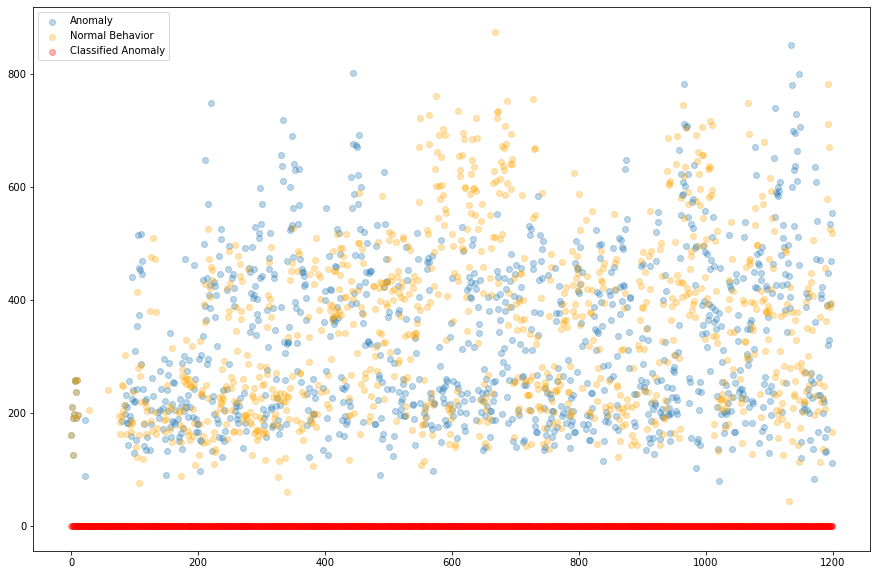

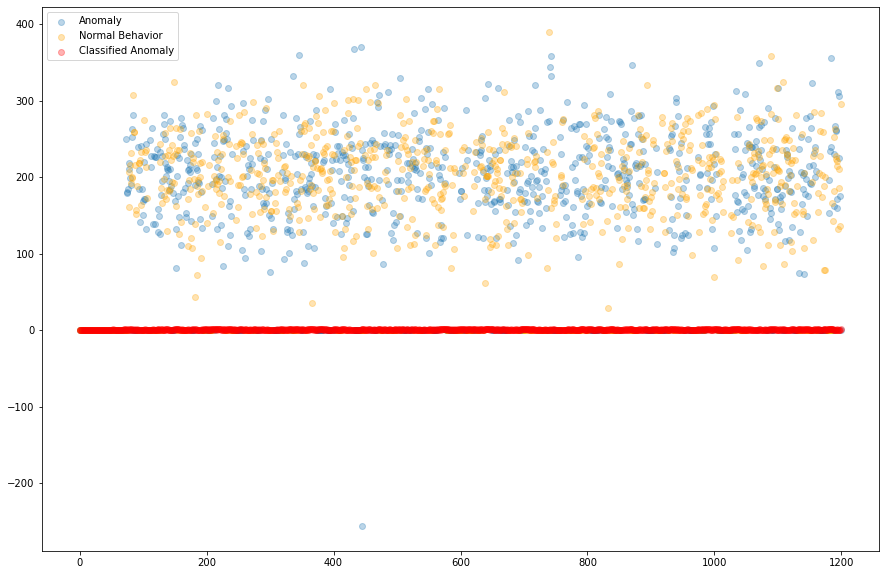

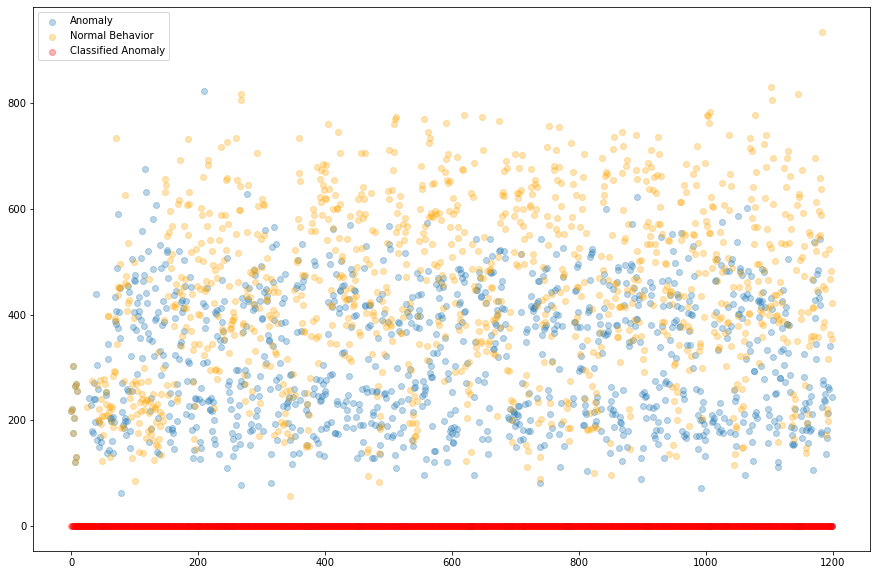

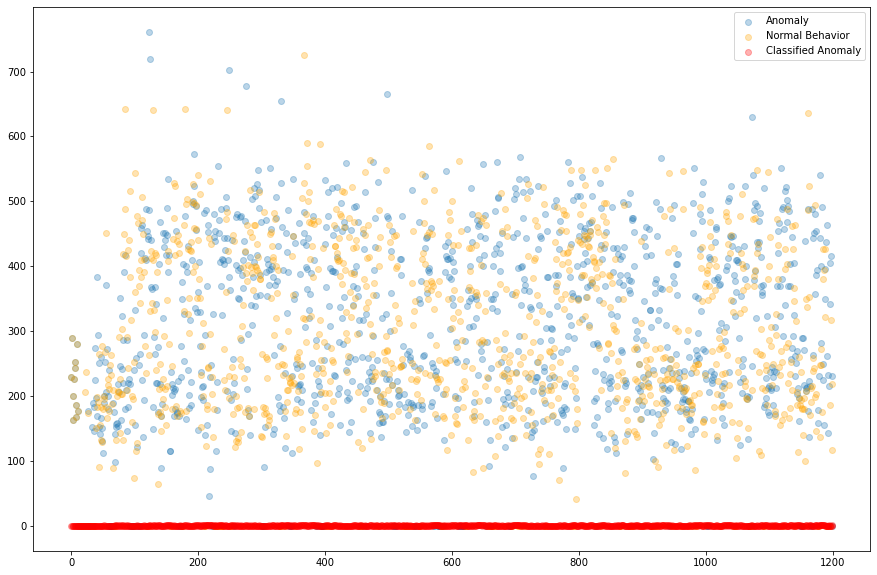

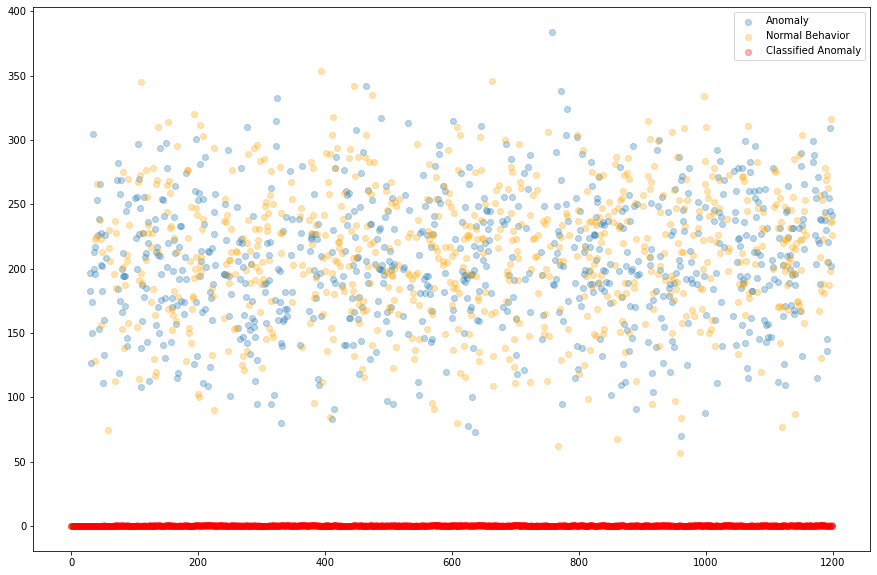

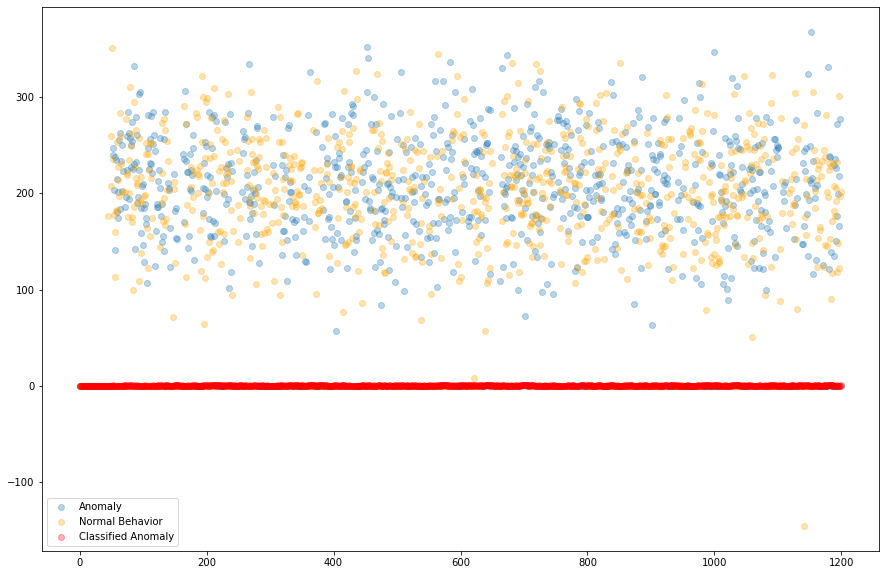

In [170]:
for host in column_names:
    plot_num_packets_overlay_attack(net1_subtracted_data, net2_with_labels, host)

In [171]:
net1_subtracted_data

13       6      9     24      8      5     29       2       3  \
0     197.0   352.0  475.0    0.0  511.0  400.0    0.0   500.0   474.0   
1     185.0   362.0  397.0    0.0  377.0  318.0    0.0   358.0   512.0   
2     151.0   406.0  330.0    0.0  466.0  439.0    0.0   463.0   302.0   
3     223.0   446.0  437.0    0.0  448.0  374.0    0.0   448.0   428.0   
4       0.0   207.0    0.0    0.0  577.0  590.0    0.0   258.0   353.0   
...     ...     ...    ...    ...    ...    ...    ...     ...     ...   
1195  715.0   878.0  796.0  234.0  185.0  569.0    0.0   798.0  1343.0   
1196  698.0  1158.0  630.0  133.0  245.0  727.0    0.0  1294.0  1091.0   
1197  529.0   994.0  425.0  192.0  764.0  576.0  182.0  1107.0  1313.0   
1198  567.0  1321.0  921.0  141.0  590.0  507.0  204.0  1032.0  1217.0   
1199  454.0  1206.0  677.0  176.0  646.0  433.0  247.0  1202.0  1172.0   

           1  ...   25     16     11     18     15     21     14     17  \
0      532.0  ...  0.0  162.0  250.0  256.0  161.0    0.0  217.0  229.0   
1      437.0  ...  0.0  226.0  141.0  251.0  210.0    0.0  221.0  289.0   
2      382.0  ...  0.0  345.0  192.0  146.0  191.0    0.0  177.0  200.0   
3      454.0  ...  0.0  178.0  175.0  187.0  125.0    0.0  303.0  163.0   
4      278.0  ...  0.0  157.0  214.0  114.0  199.0    0.0  205.0  227.0   
...      ...  ...  ...    ...    ...    ...    ...    ...    ...    ...   
1195  1344.0  ...  0.0  224.0  312.0  430.0  526.0  133.0  468.0    0.0   
1196  1241.0  ...  0.0  264.0  363.0  719.0  387.0  211.0  363.0  187.0   
1197  1044.0  ...  0.0  119.0  431.0  384.0  395.0  186.0  482.0  318.0   
1198  1135.0  ...  0.0  498.0  168.0  666.0  167.0  136.0  354.0  117.0   
1199   832.0  ...  0.0  487.0  174.0  565.0  519.0  296.0  422.0  219.0   

         27     22  
0       0.0    0.0  
1       0.0    0.0  
2       0.0    0.0  
3       0.0    0.0  
4       0.0    0.0  
...     ...    ...  
1195  236.0  148.0  
1196  198.0  301.0  
1197  316.0  122.0  
1198  226.0  197.0  
1199  237.0  201.0  

[1200 rows x 30 columns]

In [173]:
net2_with_labels

13       6      9   24      8      5     29       2       3       1  \
0     197.0   352.0  475.0  0.0  511.0  400.0    0.0   500.0   474.0   532.0   
1     185.0   362.0  397.0  0.0  377.0  318.0    0.0   358.0   512.0   437.0   
2     151.0   406.0  330.0  0.0  466.0  439.0    0.0   463.0   302.0   382.0   
3     223.0   446.0  437.0  0.0  448.0  374.0    0.0   448.0   428.0   454.0   
4       0.0   207.0    0.0  0.0  577.0  590.0    0.0   258.0   353.0   278.0   
...     ...     ...    ...  ...    ...    ...    ...     ...     ...     ...   
1195  206.0   993.0  948.0  0.0    0.0  677.0  222.0   931.0  1103.0  1203.0   
1196  138.0  1128.0  941.0  0.0    0.0  565.0    0.0  1072.0  1390.0   796.0   
1197  176.0   988.0  813.0  0.0  156.0  726.0    0.0   905.0  1186.0   916.0   
1198  196.0   947.0  708.0  0.0  455.0  457.0    0.0   739.0  1375.0  1073.0   
1199  144.0   339.0  437.0  0.0  254.0    0.0    0.0   242.0   468.0   411.0   

      ...     16     11     18     15     21     14     17     27     22  \
0     ...  162.0  250.0  256.0  161.0    0.0  217.0  229.0    0.0    0.0   
1     ...  226.0  141.0  251.0  210.0    0.0  221.0  289.0    0.0    0.0   
2     ...  345.0  192.0  146.0  191.0    0.0  177.0  200.0    0.0    0.0   
3     ...  178.0  175.0  187.0  125.0    0.0  303.0  163.0    0.0    0.0   
4     ...  157.0  214.0  114.0  199.0    0.0  205.0  227.0    0.0    0.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1195  ...  403.0  231.0  560.0  534.0  312.0  340.0  342.0  309.0  199.0   
1196  ...  353.0  214.0  590.0  393.0  225.0    0.0  405.0  245.0  166.0   
1197  ...  488.0  312.0  600.0  469.0  306.0    0.0  416.0  202.0  218.0   
1198  ...  487.0  173.0  599.0  554.0  175.0    0.0  231.0  242.0  277.0   
1199  ...  281.0  199.0  240.0  112.0    0.0  244.0    0.0    0.0    0.0   

      attack  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
1195       0  
1196       0  
1197       0  
1198       0  
1199       1  

[1200 rows x 31 columns]

## Normalizing Data

In [174]:
# max min(0-1)
def norm(train, test):

    normalizer = MinMaxScaler(feature_range=(0, 1)).fit(train) # scale training data to [0,1] range
    train_ret = normalizer.transform(train)
    test_ret = normalizer.transform(test)

    return train_ret, test_ret

In [178]:
test = net2_with_labels
train = net1_subtracted_data
attack_column = test["attack"]

test = test.iloc[:, 1:]
train = train.iloc[:, 1:]

train = train.fillna(train.mean())
test = test.fillna(test.mean())
train = train.fillna(0)
test = test.fillna(0)

train_columns = train.columns
test_columns = test.columns

# trim column names
train = train.rename(columns=lambda x: x.strip())
test = test.rename(columns=lambda x: x.strip())

print(len(test.columns),test.columns)
print(len(train.columns),train.columns)


# train_labels = train.attack
test_labels = test.attack

# train = train.drop(columns=['attack'])
test = test.drop(columns=['attack'])


x_train, x_test = norm(train.values, test.values)

30 Index(['6', '9', '24', '8', '5', '29', '2', '3', '1', '7', '19', '23', '12',
       '20', '10', '28', '4', '0', '26', '25', '16', '11', '18', '15', '21',
       '14', '17', '27', '22', 'attack'],
      dtype='object')
29 Index(['6', '9', '24', '8', '5', '29', '2', '3', '1', '7', '19', '23', '12',
       '20', '10', '28', '4', '0', '26', '25', '16', '11', '18', '15', '21',
       '14', '17', '27', '22'],
      dtype='object')


In [179]:
train_df = pd.DataFrame(x_train, columns = train_columns)
test_df =pd.DataFrame(x_test, columns = test_columns[:-1])
train_df.head()

6         9   24         8         5        29         2         3  \
0  0.163645  0.272206  0.0  0.285634  0.158044  0.095855  0.227169  0.264952   
1  0.168294  0.227507  0.0  0.210732  0.111427  0.095855  0.162653  0.286193   
2  0.188749  0.189112  0.0  0.260481  0.180216  0.095855  0.210359  0.168809   
3  0.207345  0.250430  0.0  0.250419  0.143263  0.095855  0.203544  0.239240   
4  0.096234  0.000000  0.0  0.322527  0.266060  0.095855  0.117219  0.197317   

          1         7  ...   25        16        11        18        15   21  \
0  0.325581  0.356633  ...  0.0  0.215712  0.340599  0.351410  0.184211  0.0   
1  0.267442  0.260714  ...  0.0  0.300932  0.192098  0.345987  0.240275  0.0   
2  0.233782  0.300510  ...  0.0  0.459387  0.261580  0.232104  0.218535  0.0   
3  0.277846  0.298469  ...  0.0  0.237017  0.238420  0.276573  0.143021  0.0   
4  0.170135  0.213265  ...  0.0  0.209055  0.291553  0.197397  0.227689  0.0   

         14        17   27        22  
0  0.232086  0.315427  0.0  0.293763  
1  0.236364  0.398072  0.0  0.293763  
2  0.189305  0.275482  0.0  0.293763  
3  0.324064  0.224518  0.0  0.293763  
4  0.219251  0.312672  0.0  0.293763  

[5 rows x 29 columns]

## Saving Cleaned Data for GDN  

In [180]:
test_df["attack"] = attack_column

In [189]:
def descriptive_column_names(df):
    new_column_names = {}
    for column in df.columns:
        if column != "attack":
            new_column_names[column] = "host_"+column
    return new_column_names

In [192]:
train_df.rename(columns=descriptive_column_names(train_df))
test_df.rename(columns=descriptive_column_names(test_df))

host_6    host_9  host_24    host_8    host_5   host_29    host_2  \
0     0.163645  0.272206      0.0  0.285634  0.158044  0.095855  0.227169   
1     0.168294  0.227507      0.0  0.210732  0.111427  0.095855  0.162653   
2     0.188749  0.189112      0.0  0.260481  0.180216  0.095855  0.210359   
3     0.207345  0.250430      0.0  0.250419  0.143263  0.095855  0.203544   
4     0.096234  0.000000      0.0  0.322527  0.266060  0.095855  0.117219   
...        ...       ...      ...       ...       ...       ...       ...   
1195  0.461646  0.543266      0.0  0.000000  0.315520  0.670984  0.422990   
1196  0.524407  0.539255      0.0  0.000000  0.251848  0.095855  0.487051   
1197  0.459321  0.465903      0.0  0.087200  0.343377  0.095855  0.411177   
1198  0.440260  0.405731      0.0  0.254332  0.190449  0.095855  0.335756   
1199  0.157601  0.250430      0.0  0.141979 -0.069358  0.095855  0.109950   

        host_3    host_1    host_7  ...   host_16   host_11   host_18  \
0     0.264952  0.325581  0.356633  ...  0.215712  0.340599  0.351410   
1     0.286193  0.267442  0.260714  ...  0.300932  0.192098  0.345987   
2     0.168809  0.233782  0.300510  ...  0.459387  0.261580  0.232104   
3     0.239240  0.277846  0.298469  ...  0.237017  0.238420  0.276573   
4     0.197317  0.170135  0.213265  ...  0.209055  0.291553  0.197397   
...        ...       ...       ...  ...       ...       ...       ...   
1195  0.616546  0.736230  0.596429  ...  0.536618  0.314714  0.681128   
1196  0.776970  0.487148  0.551531  ...  0.470040  0.291553  0.713666   
1197  0.662940  0.560588  0.611735  ...  0.649800  0.425068  0.724512   
1198  0.768586  0.656671  0.559694  ...  0.648469  0.235695  0.723427   
1199  0.261599  0.251530  0.165306  ...  0.374168  0.271117  0.334056   

       host_15   host_21   host_14   host_17   host_27   host_22  attack  
0     0.184211  0.000000  0.232086  0.315427  0.000000  0.293763       0  
1     0.240275  0.000000  0.236364  0.398072  0.000000  0.293763       0  
2     0.218535  0.000000  0.189305  0.275482  0.000000  0.293763       0  
3     0.143021  0.000000  0.324064  0.224518  0.000000  0.293763       0  
4     0.227689  0.000000  0.219251  0.312672  0.000000  0.293763       0  
...        ...       ...       ...       ...       ...       ...     ...  
1195  0.610984  0.800000  0.363636  0.471074  0.872881  0.694165       0  
1196  0.449657  0.576923  0.000000  0.557851  0.692090  0.627767       0  
1197  0.536613  0.784615  0.000000  0.573003  0.570621  0.732394       0  
1198  0.633867  0.448718  0.000000  0.318182  0.683616  0.851107       0  
1199  0.128146  0.000000  0.260963  0.000000  0.000000  0.293763       1  

[1200 rows x 30 columns]

In [193]:
train.columns

Index(['6', '9', '24', '8', '5', '29', '2', '3', '1', '7', '19', '23', '12',
       '20', '10', '28', '4', '0', '26', '25', '16', '11', '18', '15', '21',
       '14', '17', '27', '22'],
      dtype='object')

In [ ]:
train_df.to_csv("anomaly-detection-spatial-temporal-data/data/03_primary/wifi/train.csv", index=False)
test_df.to_csv("anomaly-detection-spatial-temporal-data/data/03_primary/wifi/train.csv", index=False)

with open("anomaly-detection-spatial-temporal-data/data/03_primary/wifi/list.txt", "w") as f:
    f.writelines("\n".join(train.columns))